In [1]:
import mysql.connector as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ggplot import *

/usr/local/lib/python3.5/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.5/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data retrieval

In [2]:
db_connection = sql.connect(host='', database='', user='', password='')
db_cursor = db_connection.cursor()

pd.read_sql("SELECT COUNT(*) FROM all_physical", db_connection)

COUNT(*)
0    946719

In [3]:
query = 'SELECT * FROM all_physical'
raw_data = pd.read_sql(query, db_connection)
raw_data.shape

(946719, 53)

## Data cleaning

In [4]:
raw_data.tail()

Timestamp    FIT101    LIT101 MV101 P101 P102    AIT201  \
946714   28/12/2015 9:59:55 AM  2.460366   523.043     2    2    1  262.0161   
946715   28/12/2015 9:59:56 AM  2.448836  522.9645     2    2    1  262.0161   
946716   28/12/2015 9:59:57 AM  2.434744   522.886     2    2    1  262.0161   
946717   28/12/2015 9:59:58 AM  2.428338  522.9252     2    2    1  262.0161   
946718   28/12/2015 9:59:59 AM  2.427057  522.8467     2    2    1  262.0161   

          AIT202    AIT203    FIT201   ...   P501 P502    PIT501    PIT502  \
946714  8.396437  328.5055  2.442316   ...      2    1  250.8171  1.778105   
946715  8.396437  328.5055  2.442316   ...      2    1  250.8171  1.778105   
946716  8.396437  328.6337  2.444879   ...      2    1  250.8171  1.778105   
946717  8.396437  328.6337  2.445391   ...      2    1  250.8171  1.649953   
946718  8.396437  328.6337  2.445391   ...      2    1  250.8652  1.649953   

          PIT503        FIT601 P601 P602 P603   EVENT  
946714  189.8552  0.0001281517    1    1    1  Normal  
946715  189.5027  0.0001281517    1    1    1  Normal  
946716  189.5027  0.0001281517    1    1    1  Normal  
946717  189.5027  0.0001281517    1    1    1  Normal  
946718  189.5988  0.0001281517    1    1    1  Normal  

[5 rows x 53 columns]

In [5]:
# split day and time
dates = raw_data['Timestamp'].str.strip()
dates = dates.str.split(' ', 1, expand=True)

# days of the experiment
dates[0].unique()

array(['28/12/2015', '29/12/2015', '30/12/2015', '31/12/2015', '1/1/2016',
       '2/1/2016', '22/12/2015', '23/12/2015', '24/12/2015', '25/12/2015',
       '26/12/2015', '27/12/2015'], dtype=object)

In [6]:
# remplacing dates by the day number in the experiment
days = {
    '22/12/2015' : 1,
    '23/12/2015' : 2,
    '24/12/2015' : 3,
    '25/12/2015' : 4,
    '26/12/2015' : 5,
    '27/12/2015' : 6,
    '28/12/2015' : 7,
    '29/12/2015' : 8,
    '30/12/2015' : 9,
    '31/12/2015' : 10,
    '1/1/2016' : 11,
    '2/1/2016' : 12
}
dates[0] = dates[0].replace(days)

In [20]:
# inserting Day and Time columns in lieu of Timestamp
data = raw_data
data['Day'] = dates[0]
data['Time'] = dates[1]
cols = data.columns.tolist()
cols = cols[-2:] + cols[:-2]
data = data[cols]
del data['Timestamp']

# sorting data in chronological order
data = data.sort_values(['Day','Time'], ascending=[True,True])

In [21]:
# cleaning index
data = data.reset_index(drop=True)

# adding a sample number for plotting purpose
data['Sample'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data.head()


Sample  Day         Time    FIT101    LIT101 MV101 P101 P102    AIT201  \
0       0    1  10:00:00 PM  2.630433  501.7288     2    2    1  261.3753   
1       1    1  10:00:01 PM  2.617622  501.6895     2    2    1  261.3753   
2       2    1  10:00:02 PM  2.608974   501.454     2    2    1  261.3753   
3       3    1  10:00:03 PM  2.598405  501.8858     2    2    1  261.3753   
4       4    1  10:00:04 PM  2.575986  501.8858     2    2    1  261.3753   

     AIT202   ...   P501 P502    PIT501    PIT502    PIT503    FIT601 P601  \
0  8.336837   ...      2    1  254.0855  1.041233  193.1396  6.41E-05    1   
1  8.336837   ...      2    1  254.0695  1.041233  193.1396  6.41E-05    1   
2  8.338439   ...      2    1  253.9573  1.041233  192.9794  6.41E-05    1   
3   8.33908   ...      2    1  253.9253  1.041233  192.9794  6.41E-05    1   
4   8.33908   ...      2    1  253.9253  1.041233  192.9794  6.41E-05    1   

  P602 P603   EVENT  
0    1    1  Normal  
1    1    1  Normal  
2    1    1  Normal  
3    1    1  Normal  
4    1    1  Normal  

[5 rows x 55 columns]

## Data visualisation

In [26]:
features = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102',
            'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206',
            'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302',
            'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401',
            'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503',
            'FIT601', 'P601', 'P602', 'P603']

### All plots for the full experiment period

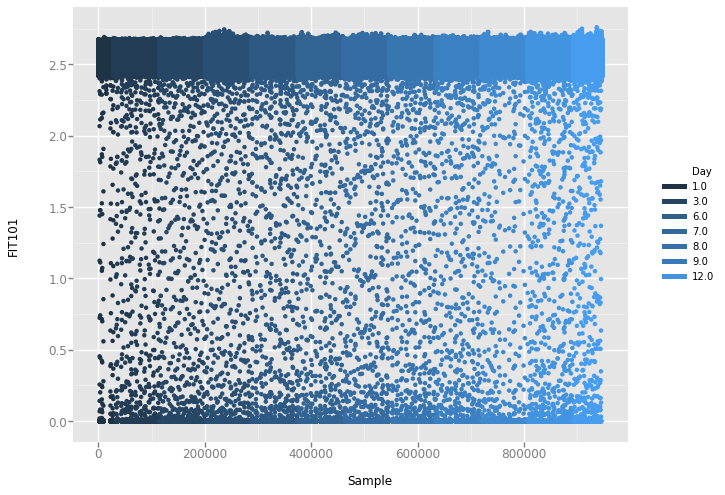

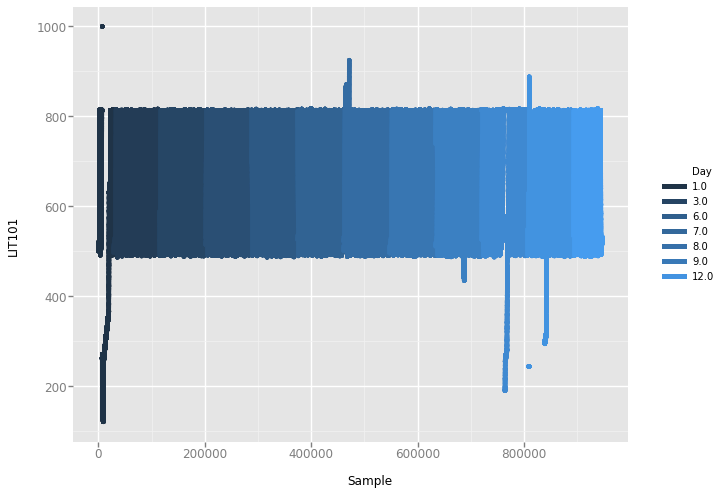

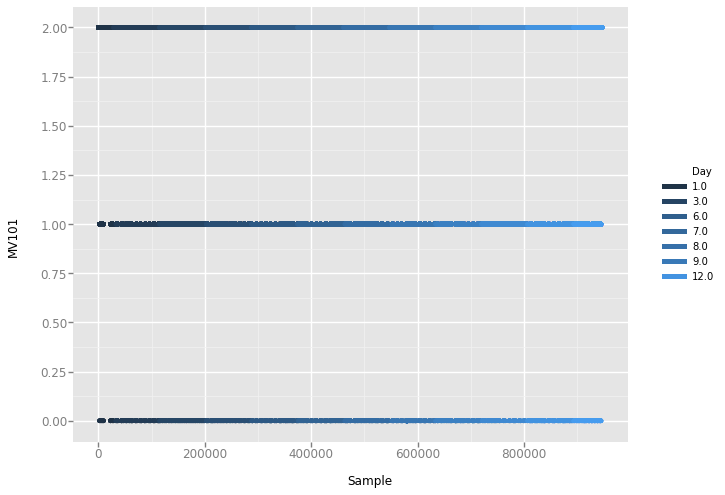

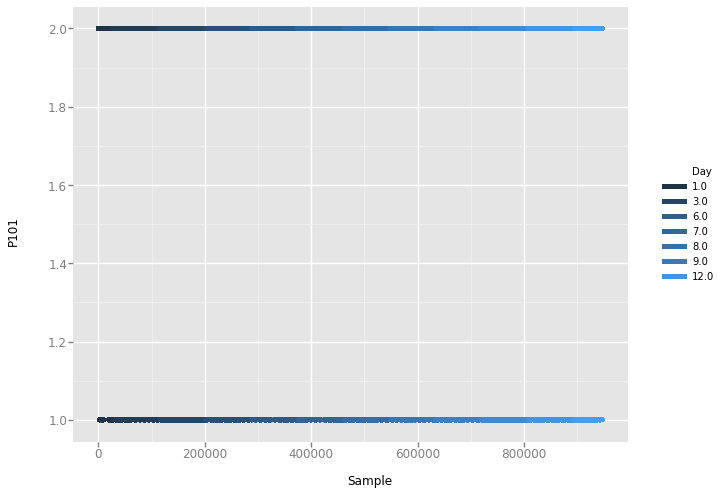

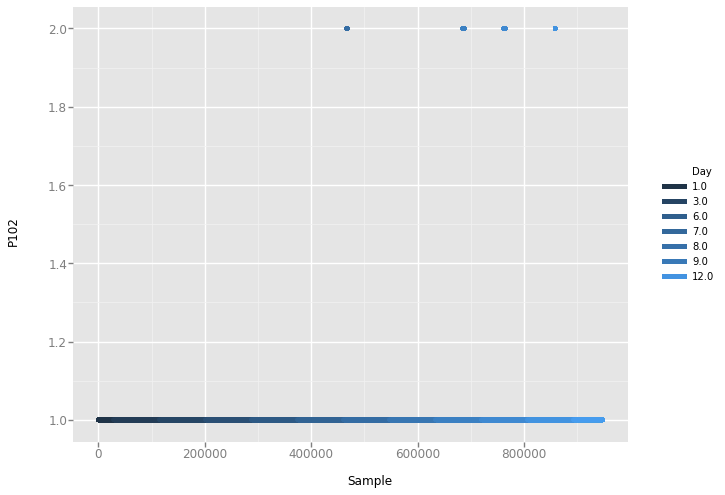

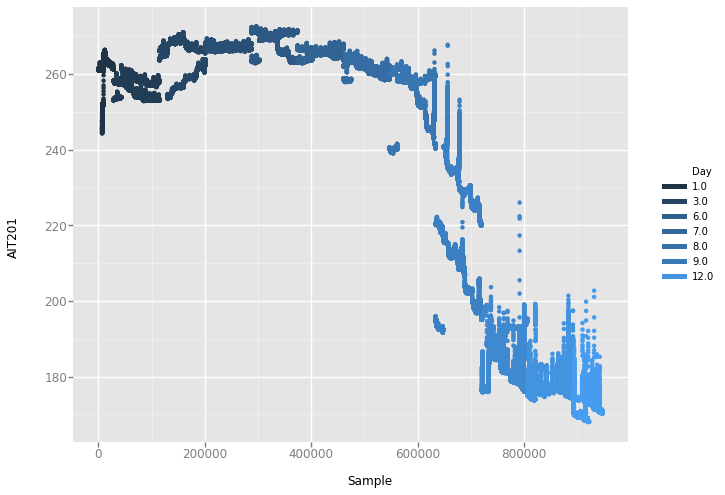

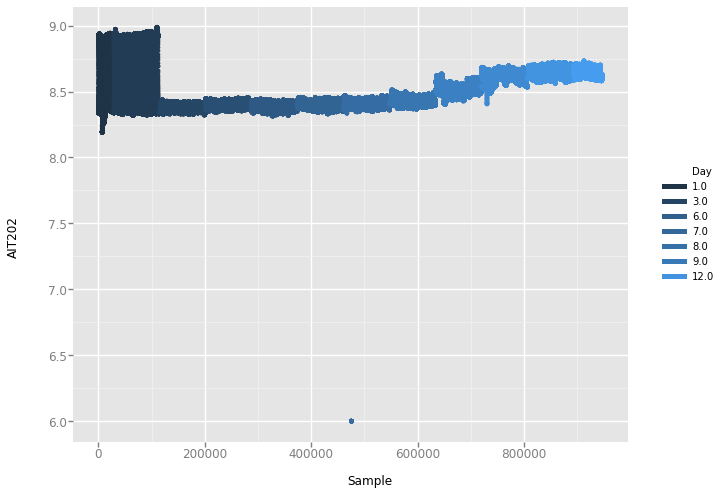

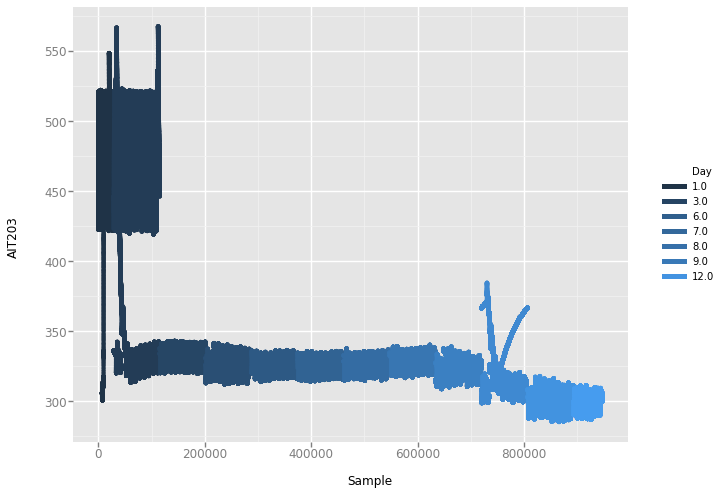

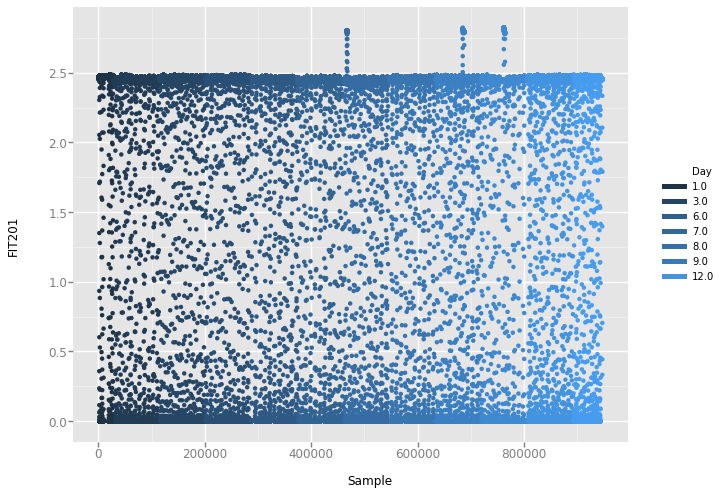

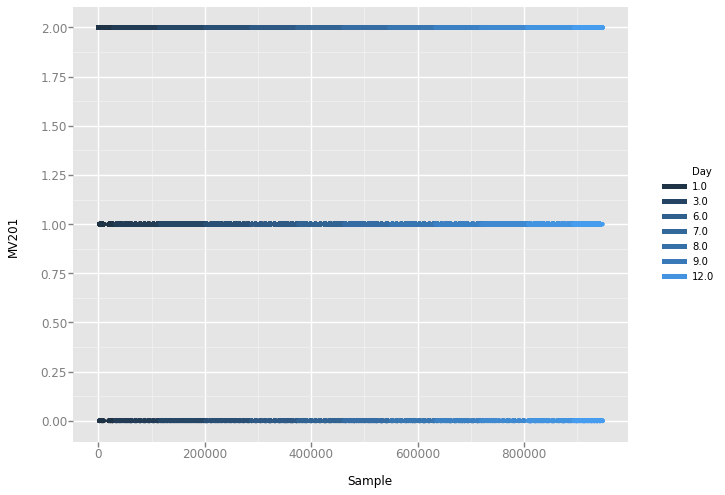

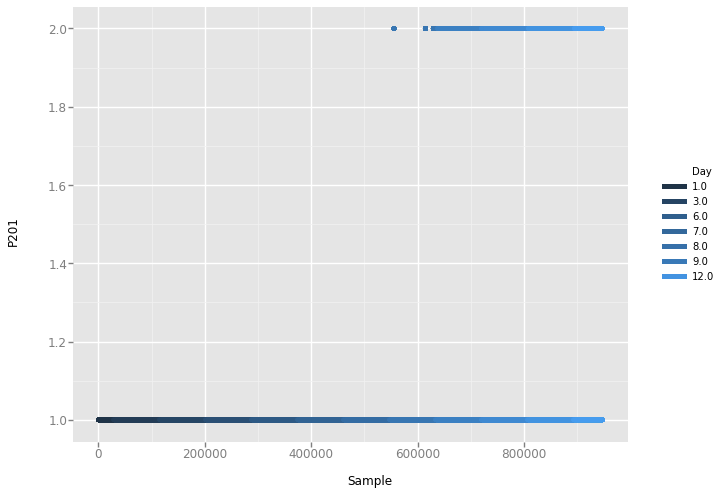

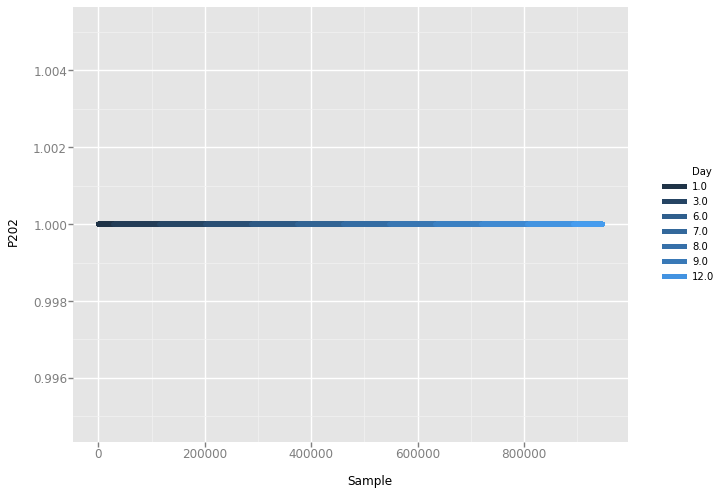

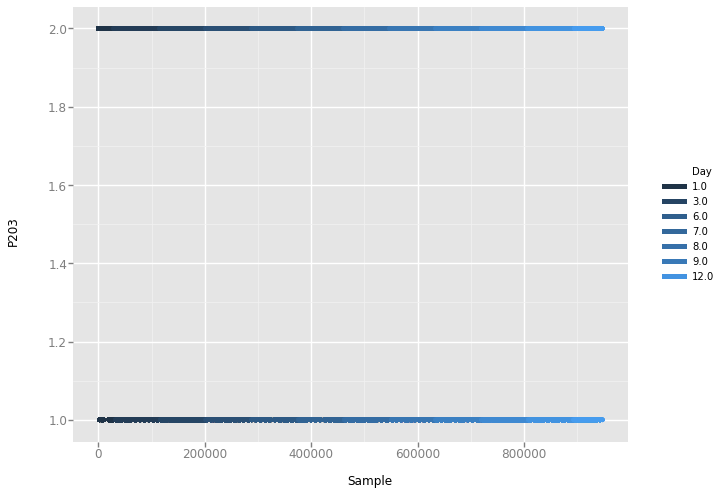

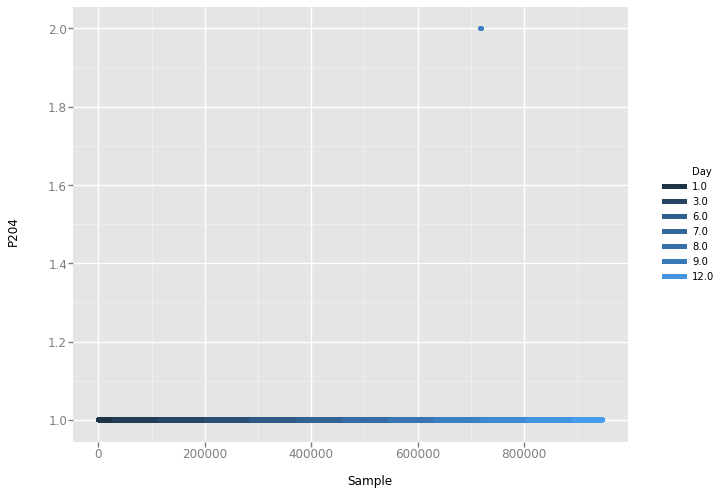

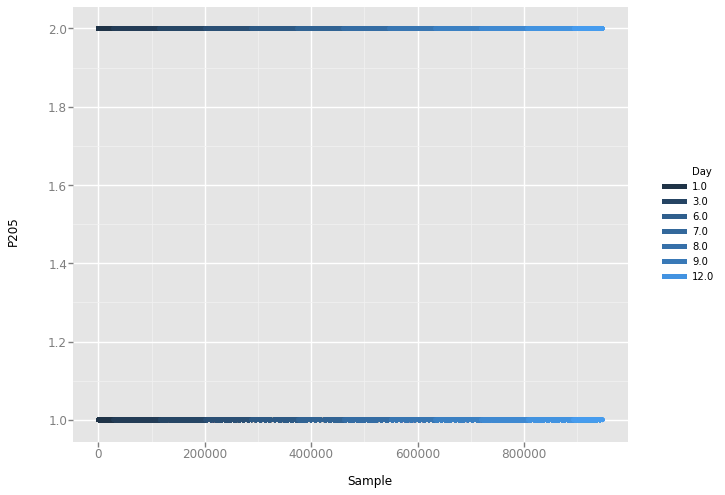

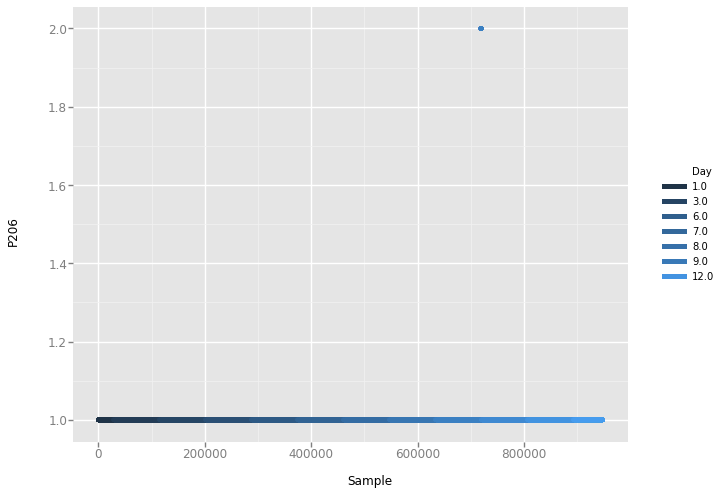

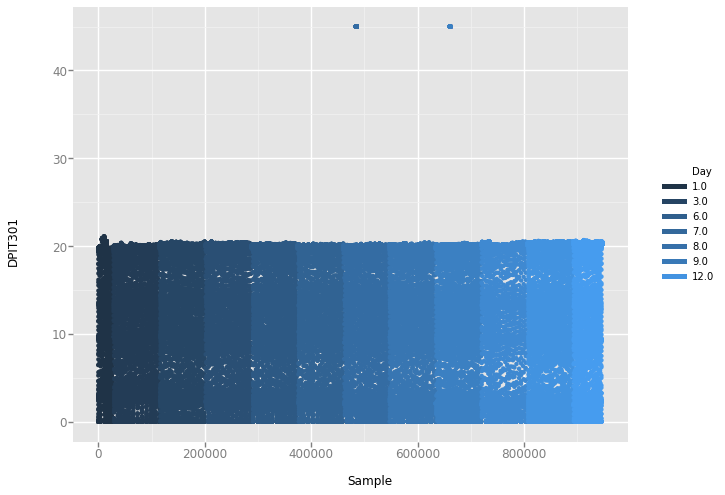

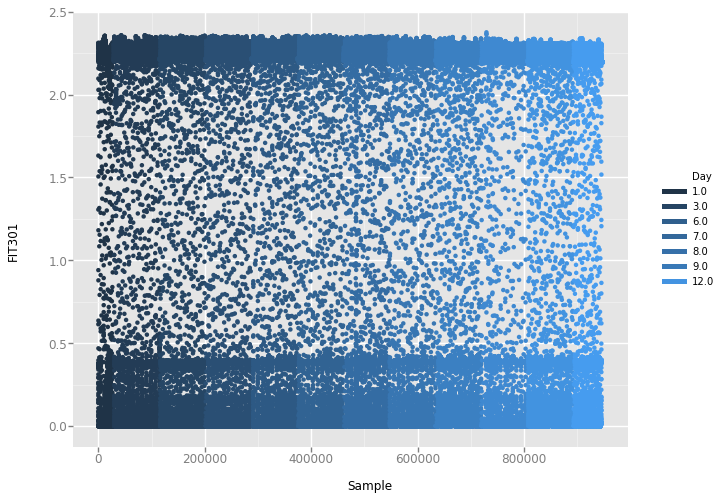

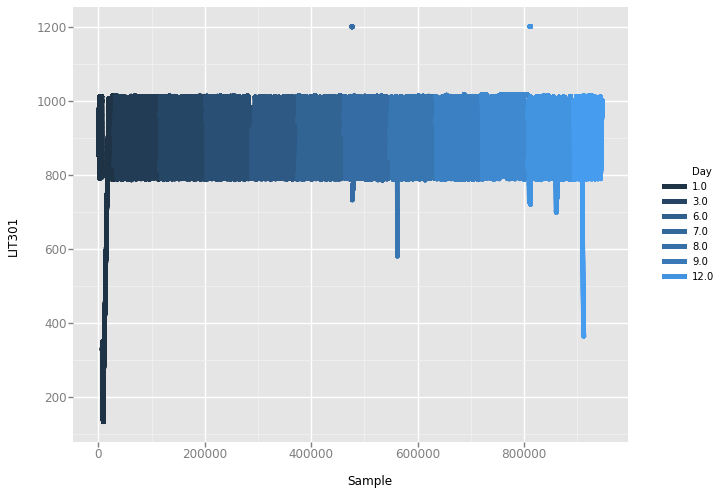

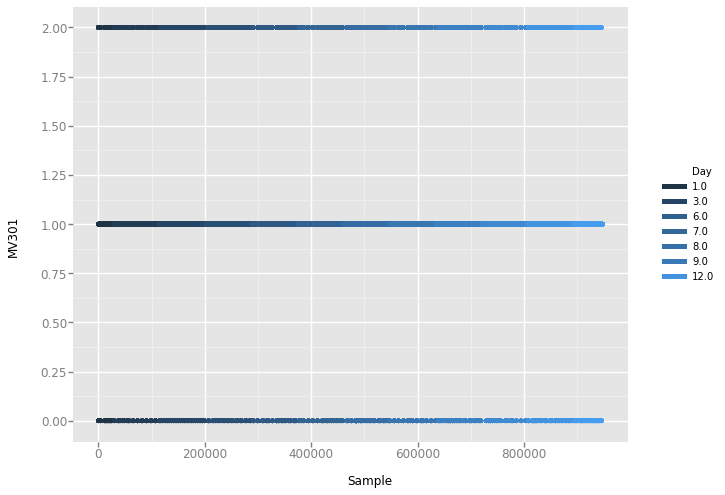

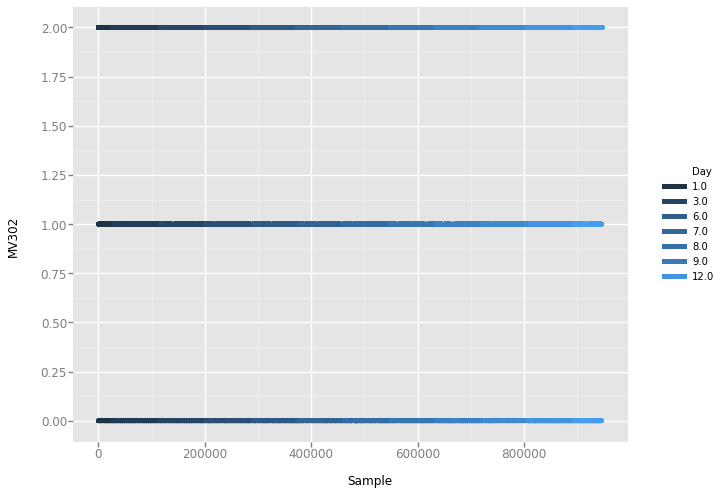

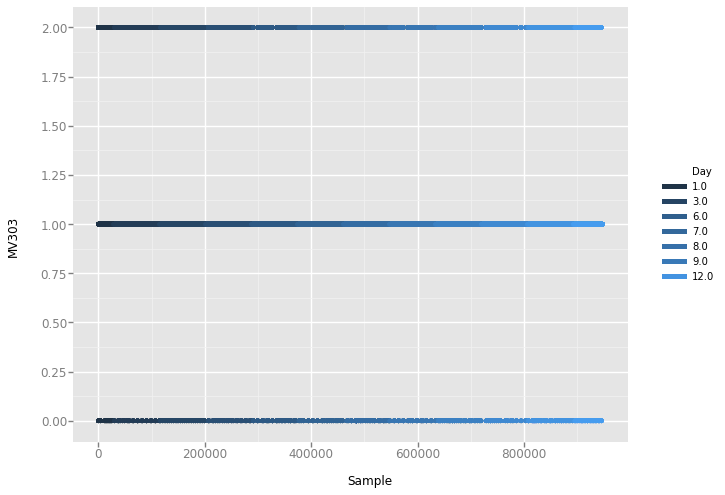

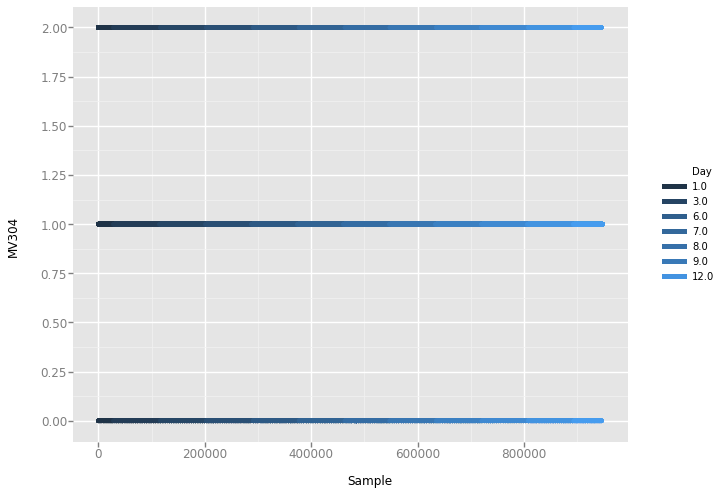

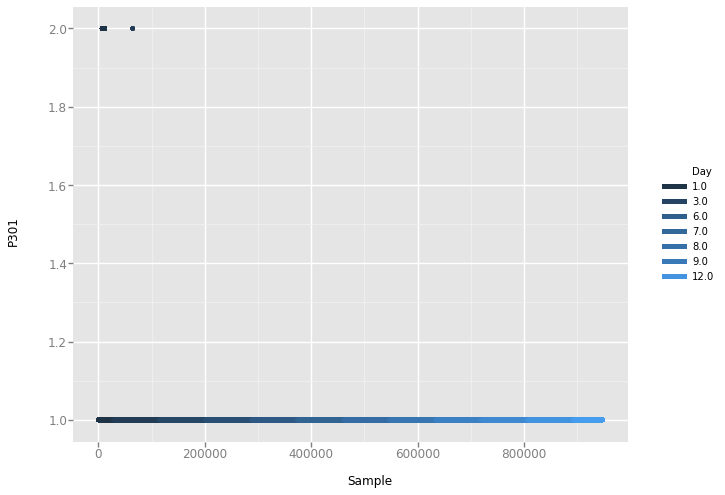

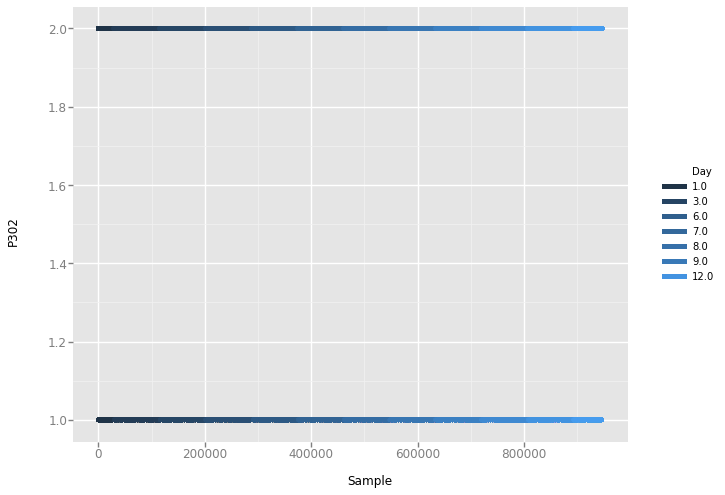

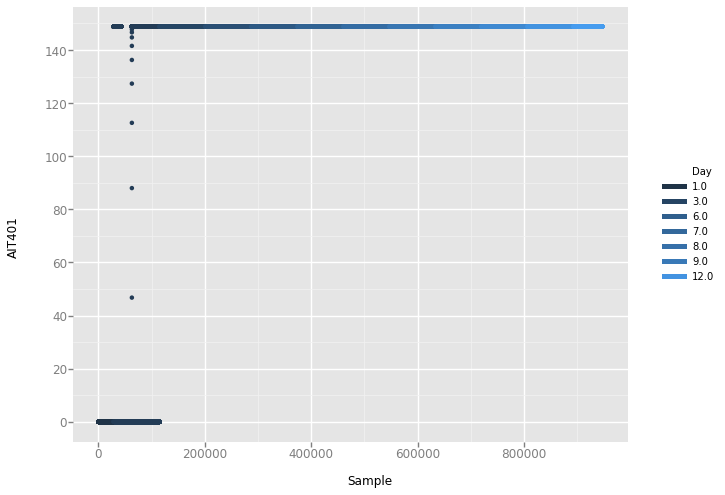

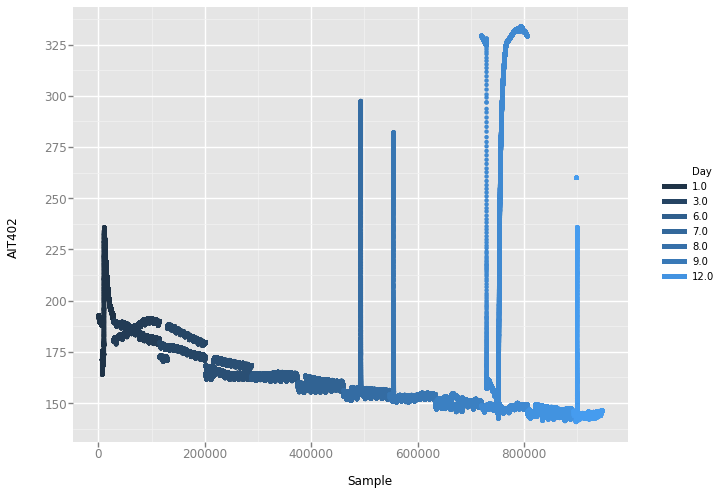

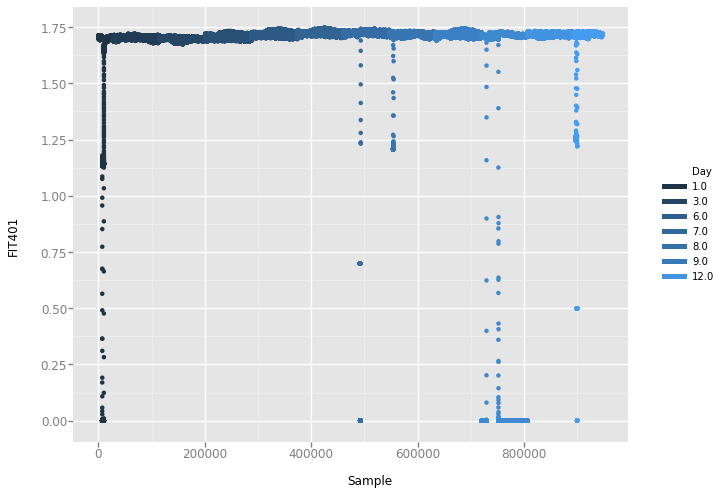

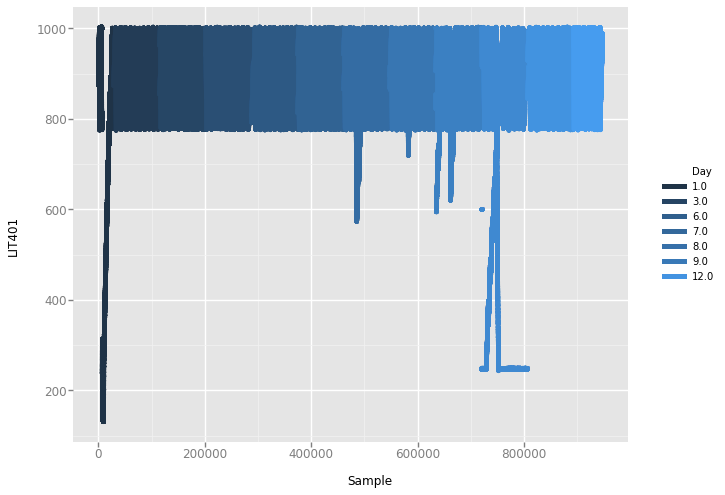

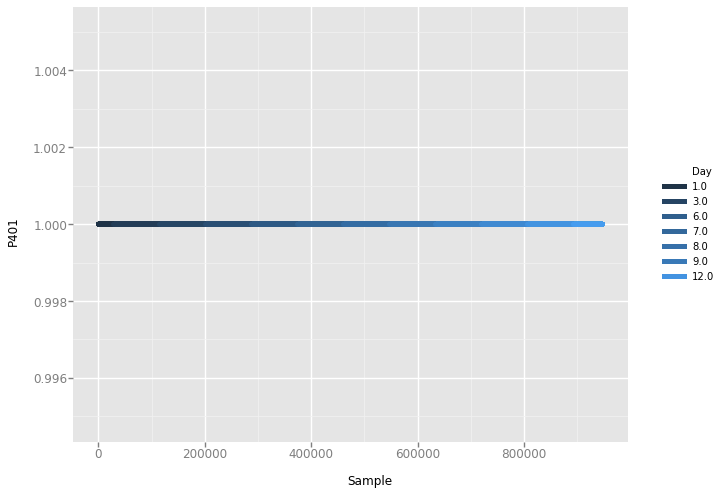

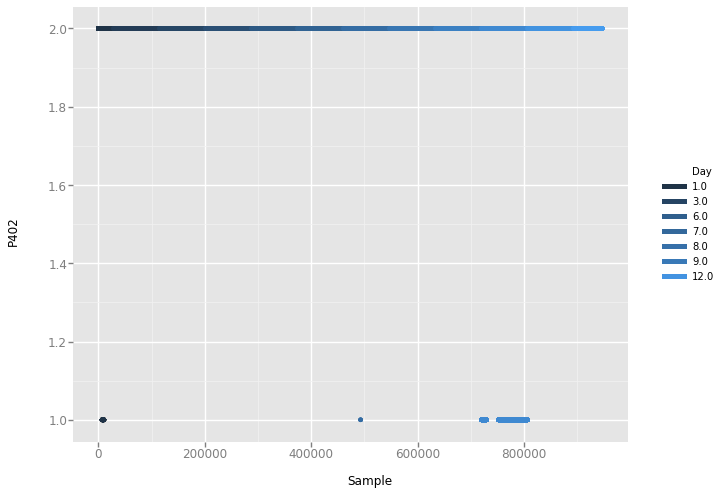

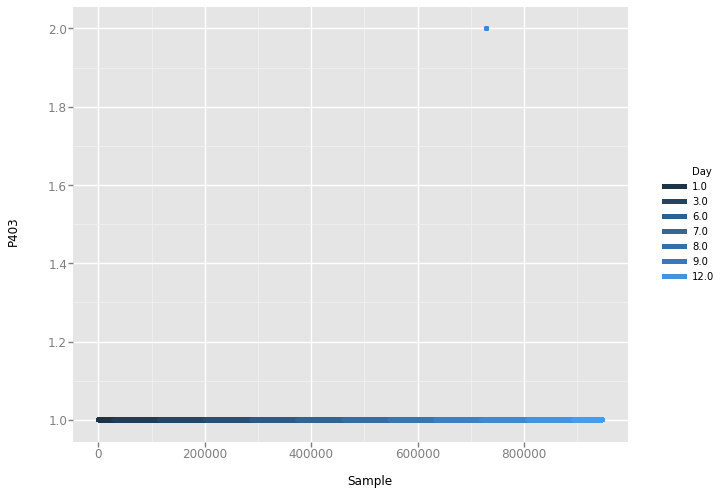

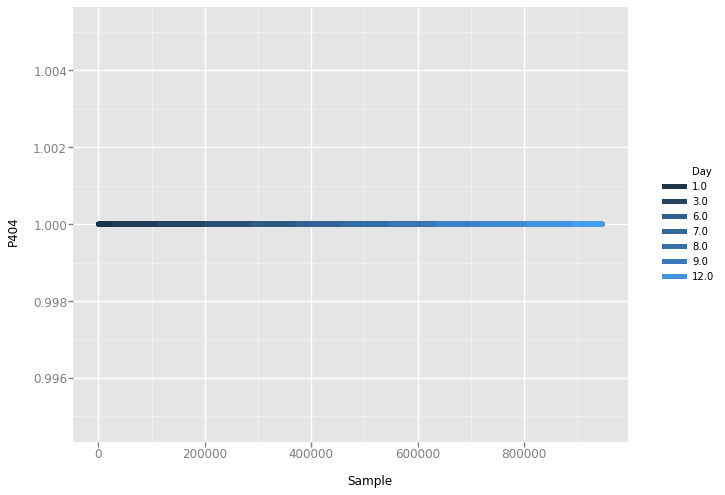

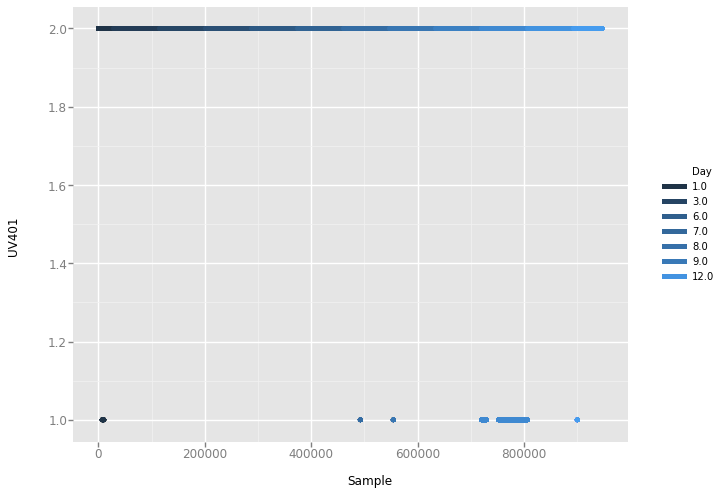

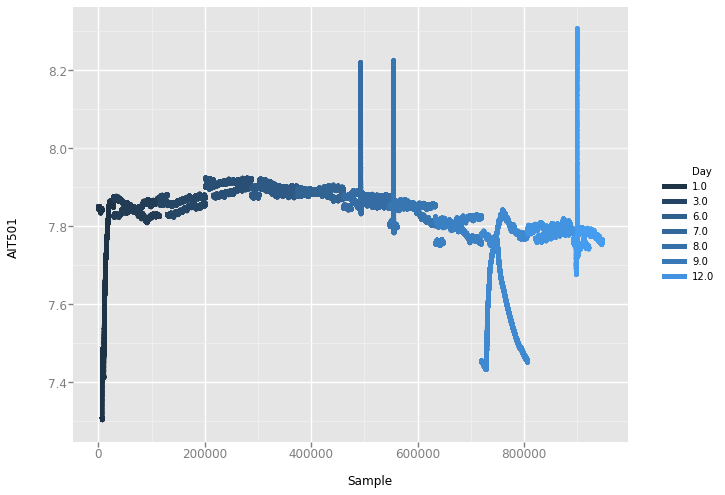

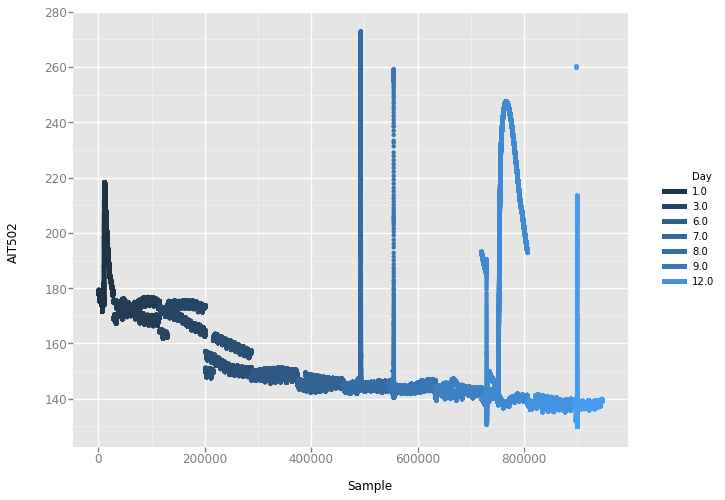

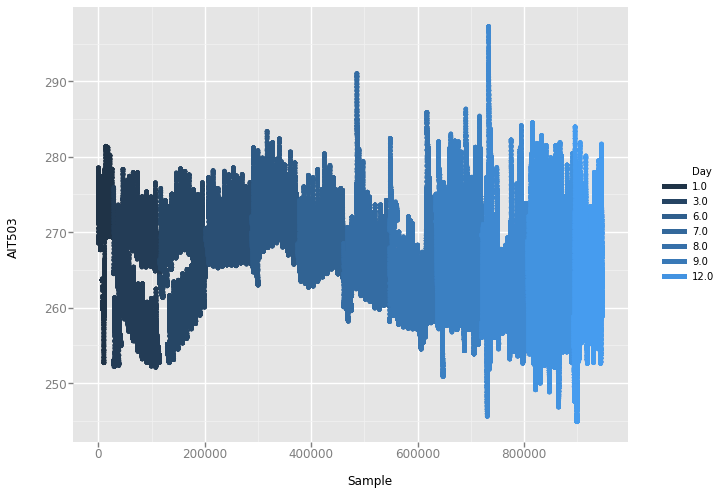

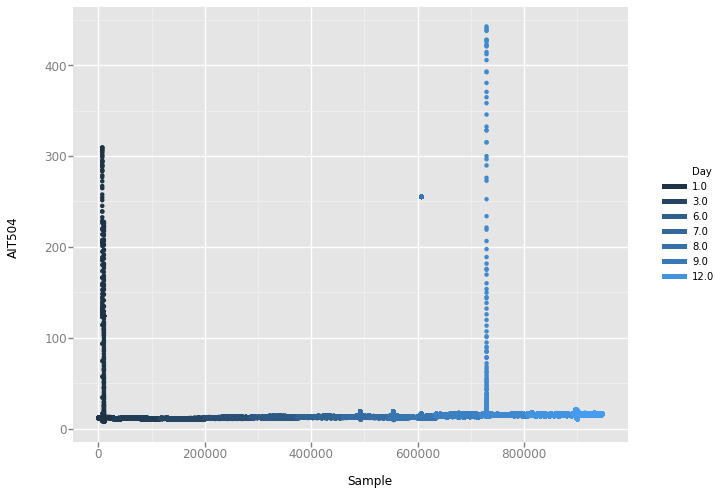

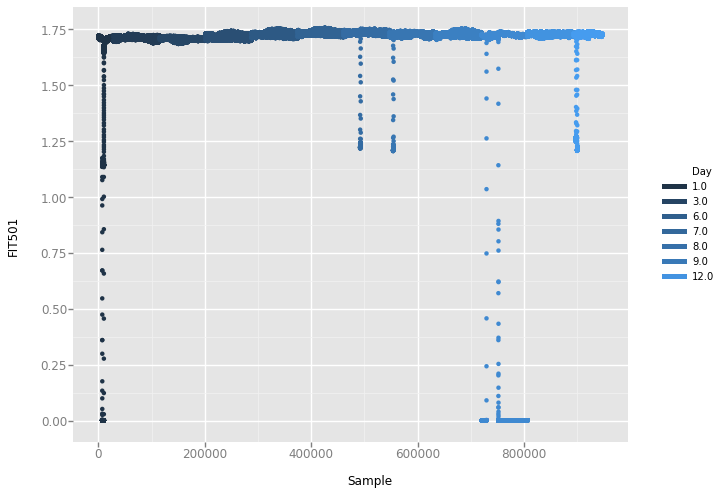

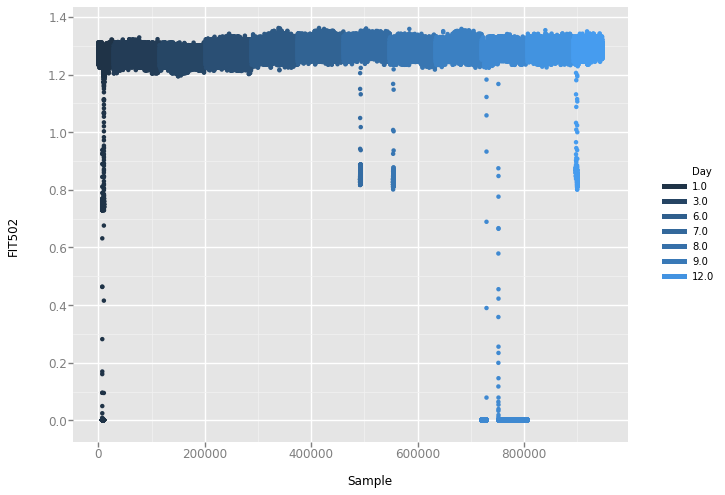

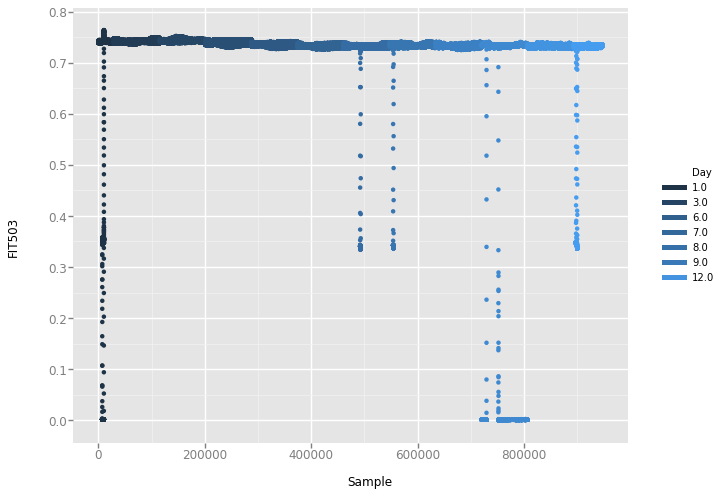

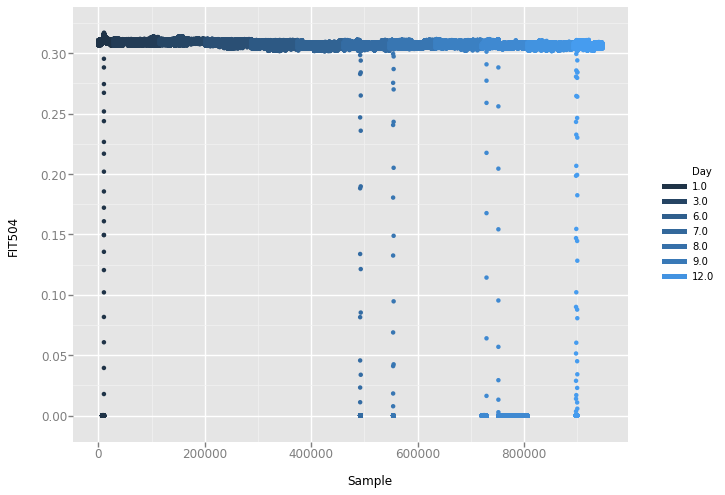

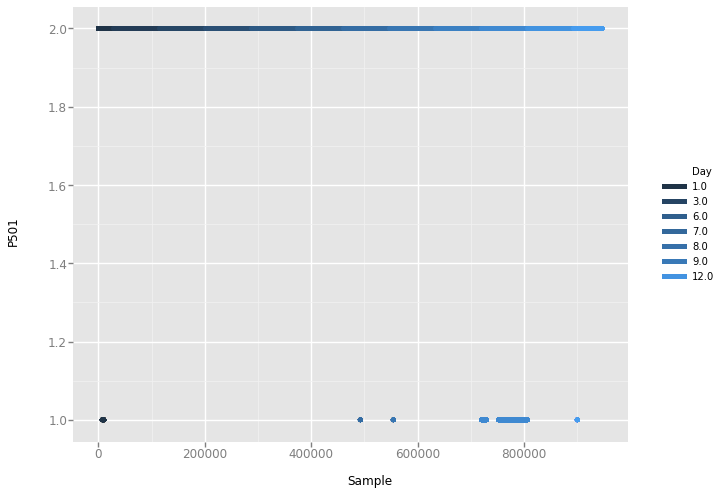

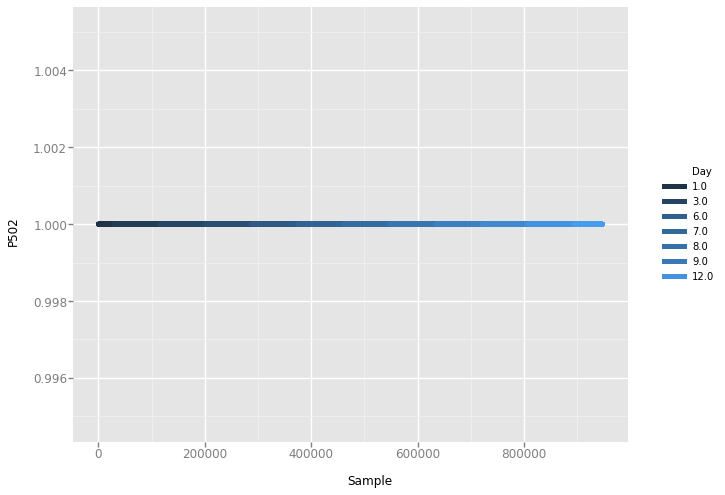

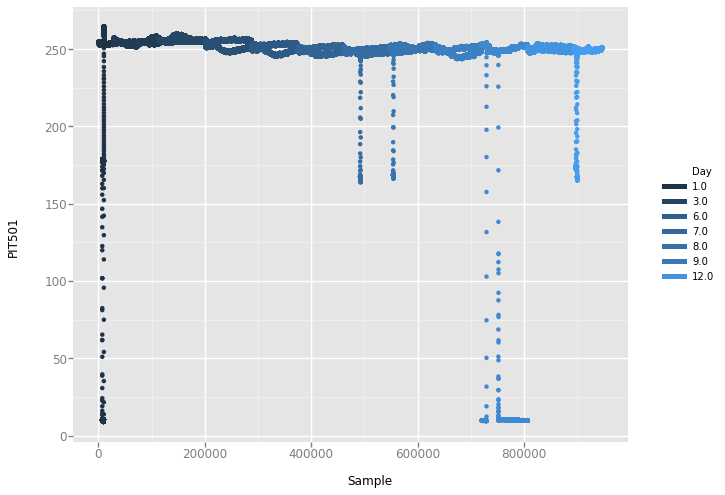

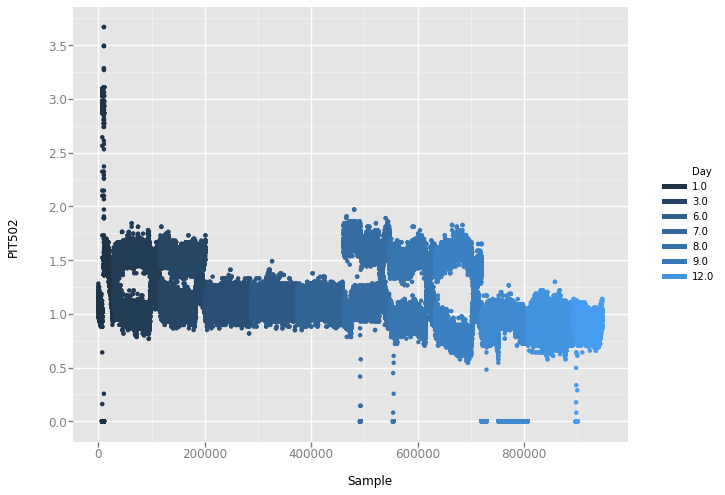

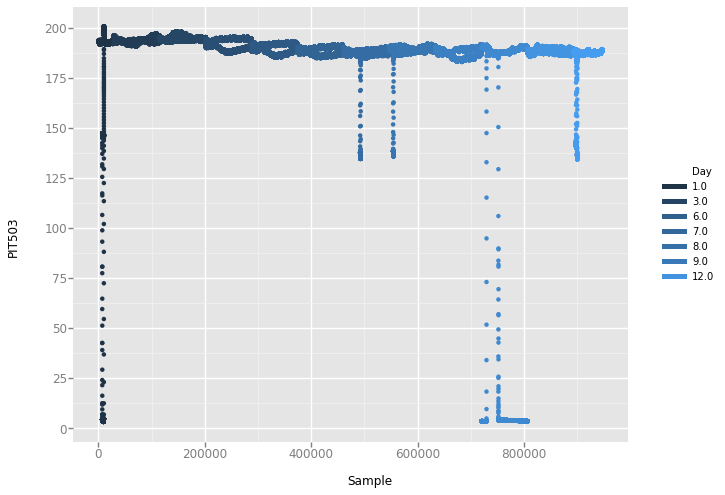

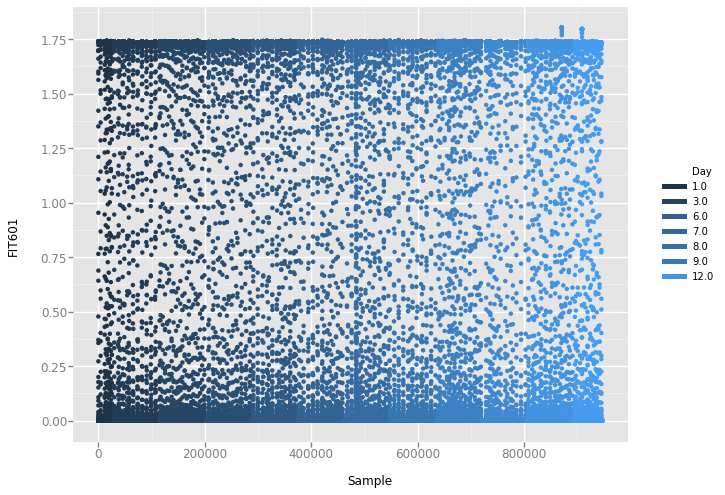

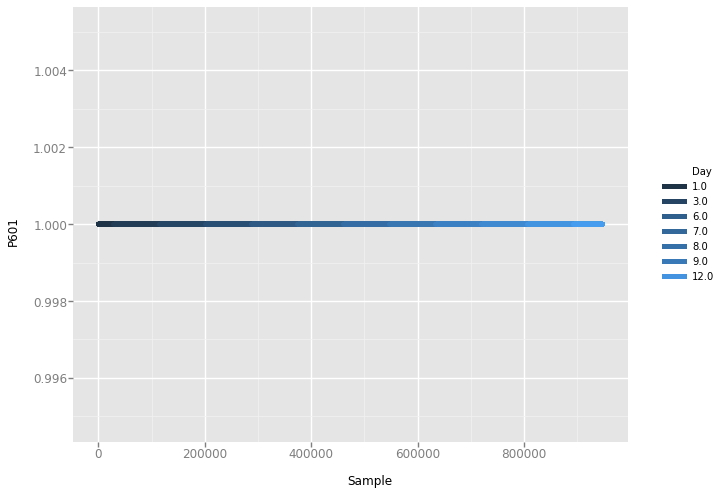

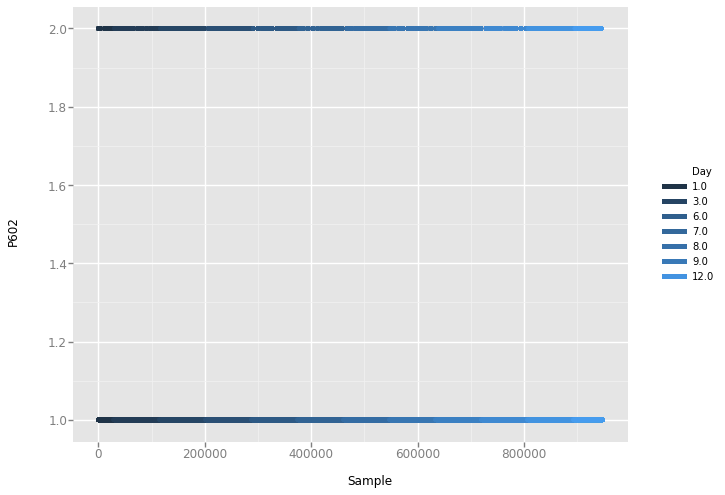

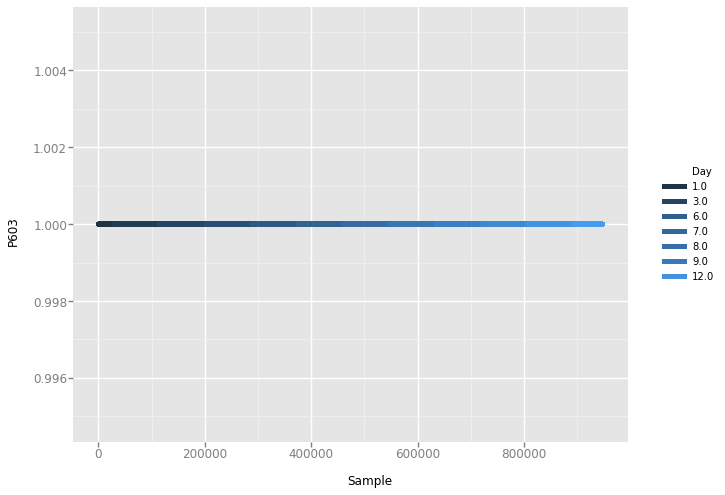

In [31]:
for feature in features:
    plot = ggplot(aes(x='Sample', y=feature, color='Day'), data=data) + \
    geom_point()
    plot.show()

### What's a normal day like?

In [37]:
# Day 1 has some glitches, let's look into day 2 specifically
is_day2 = data['Day'] == 2
data_day2 = data[is_day2]
data_day2.shape

(86400, 55)

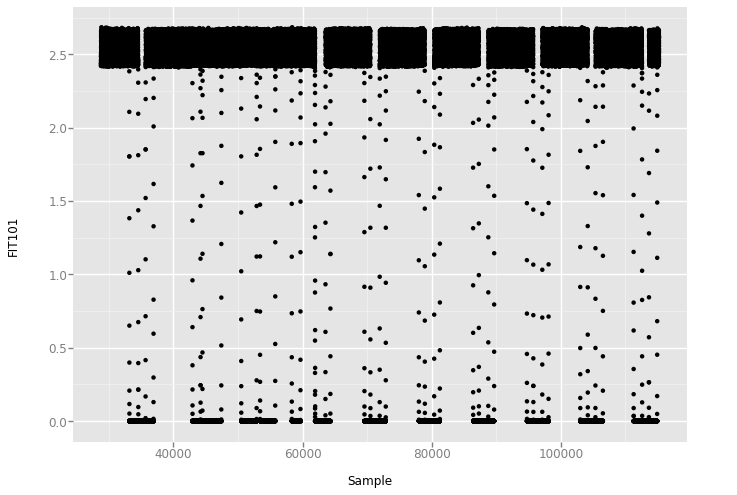

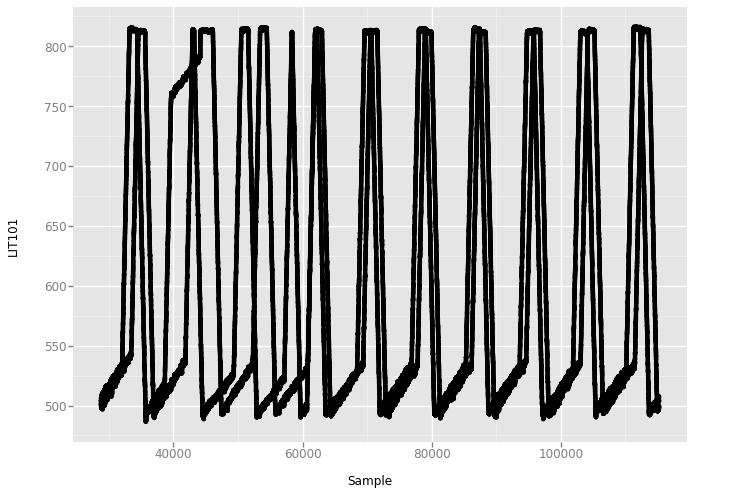

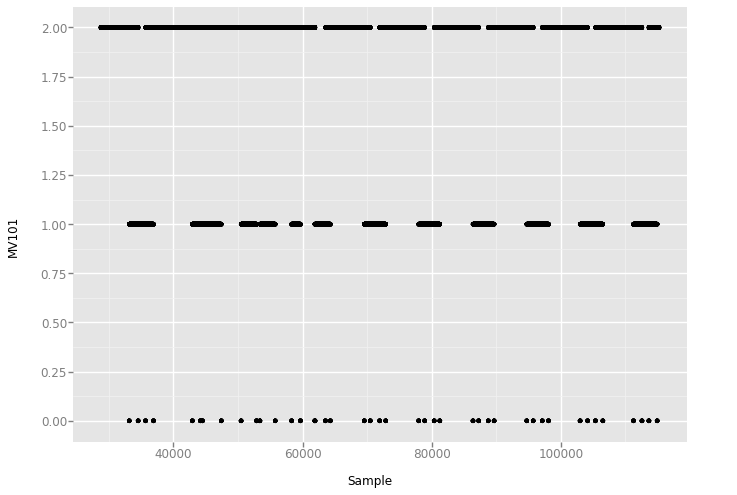

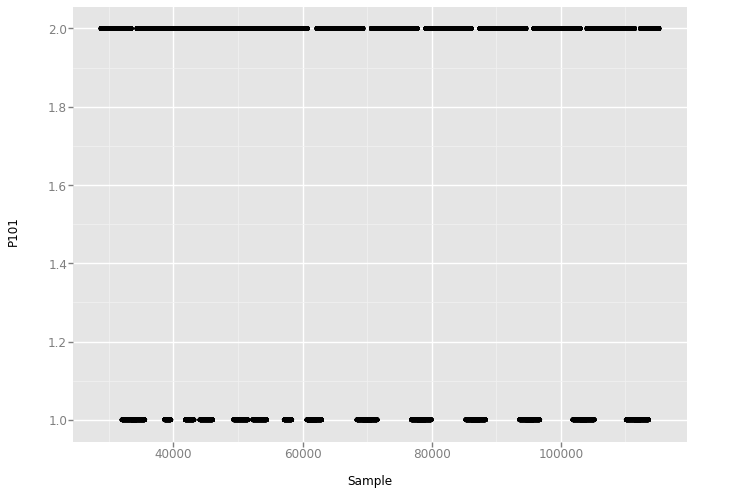

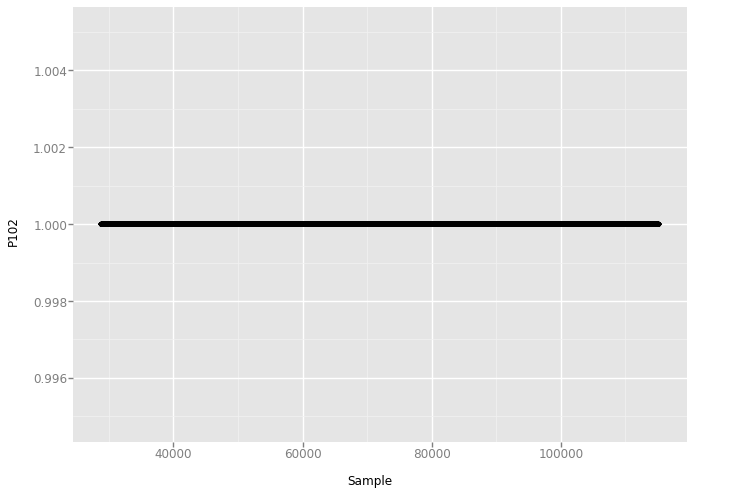

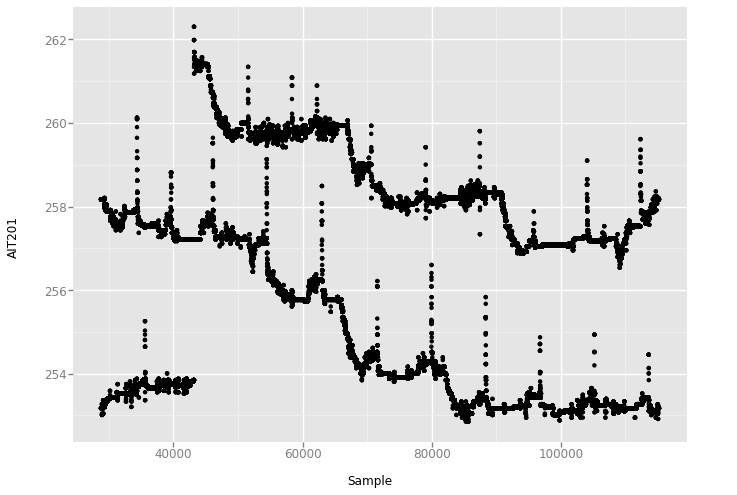

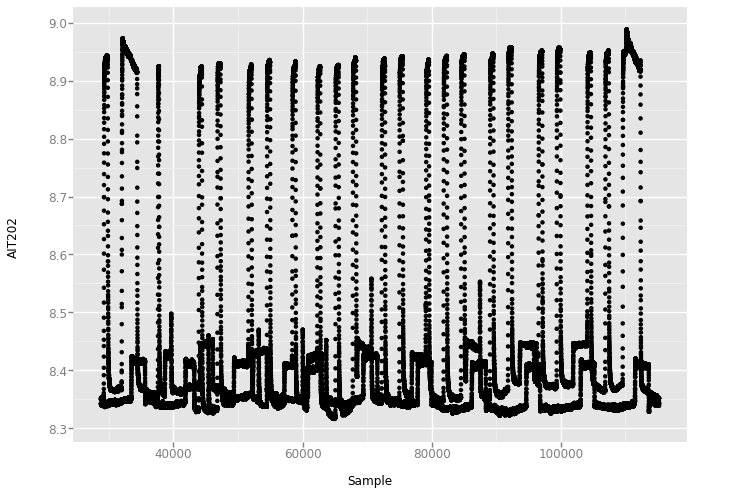

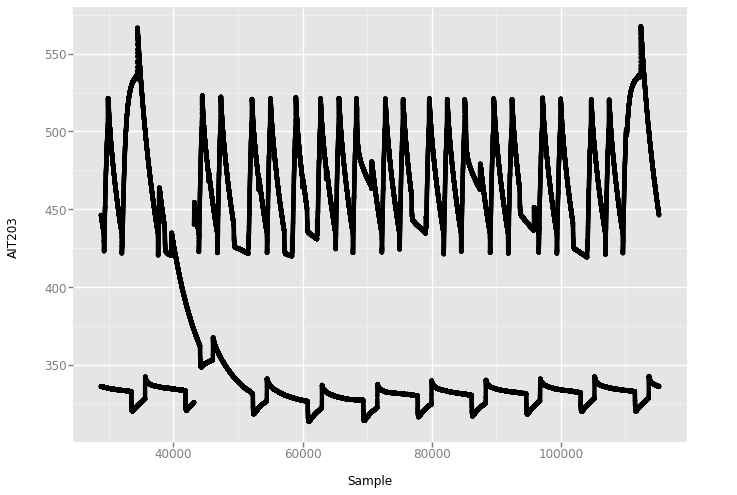

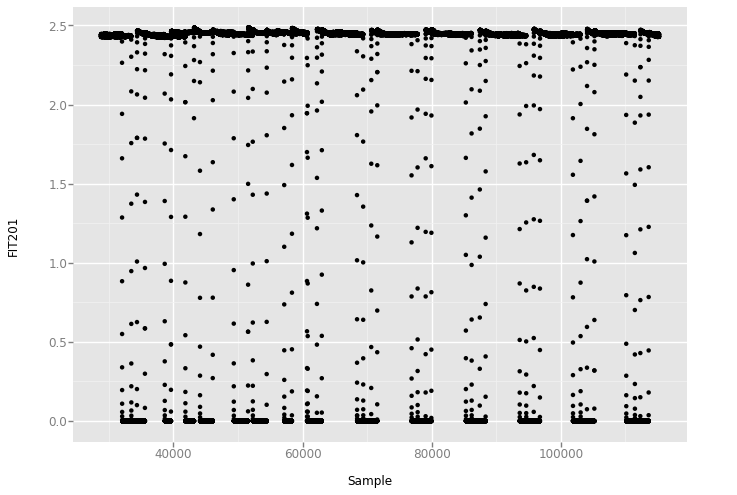

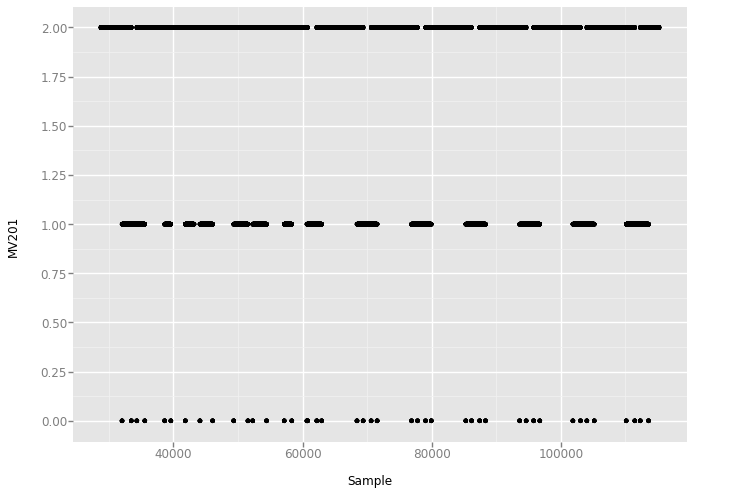

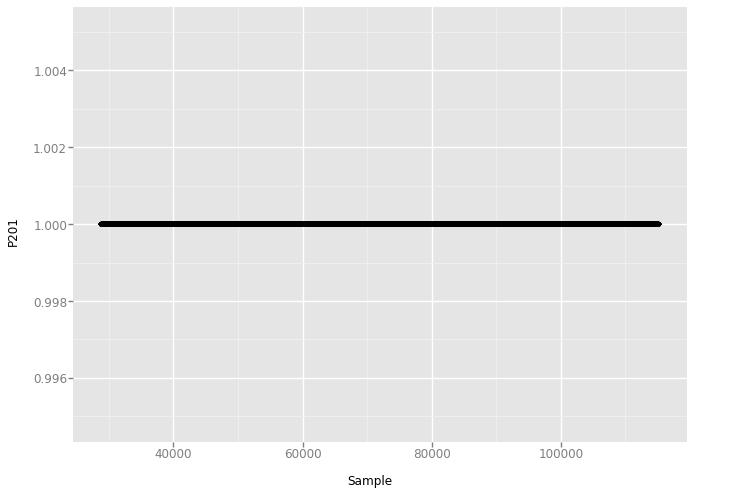

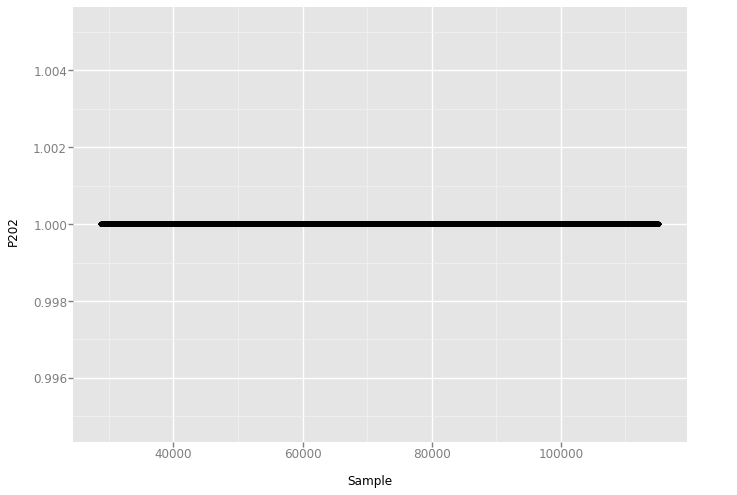

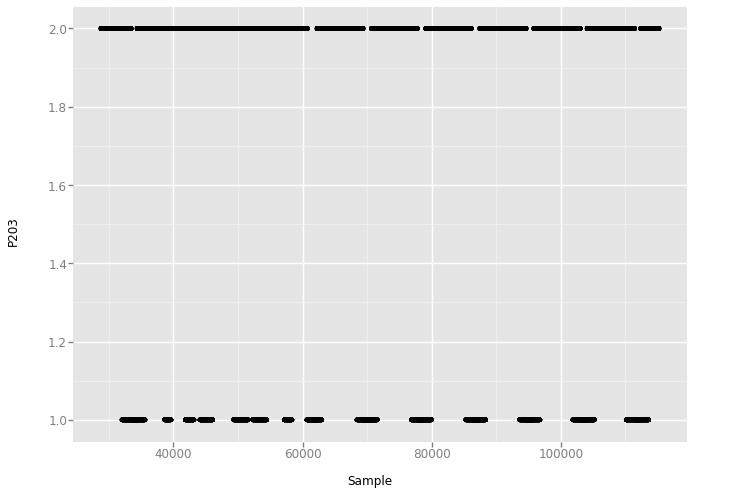

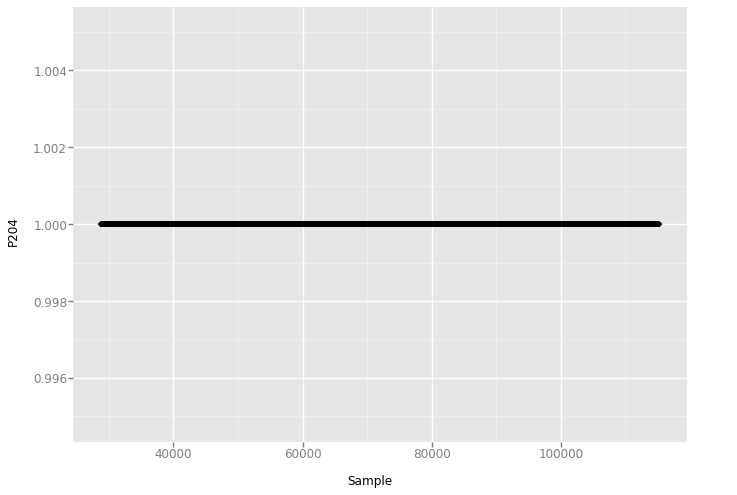

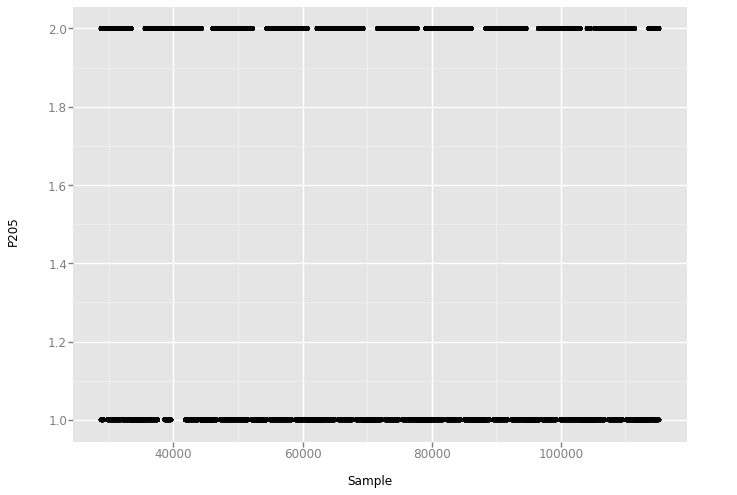

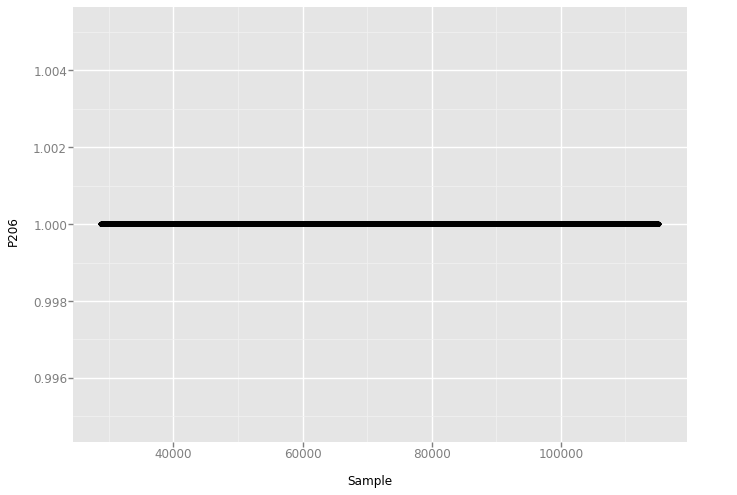

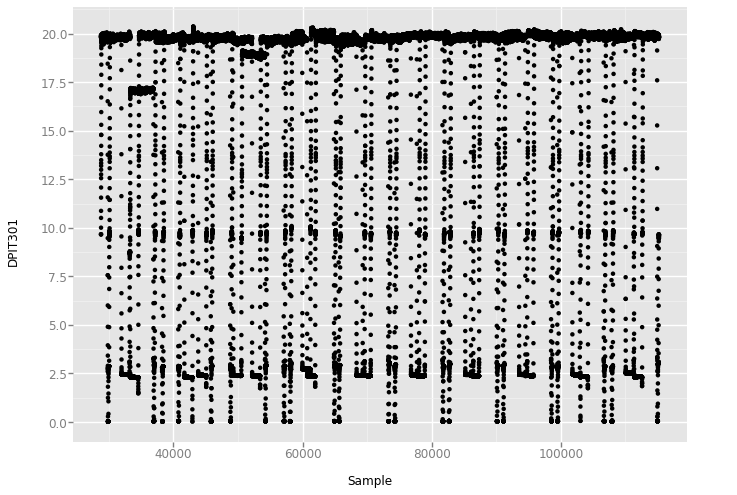

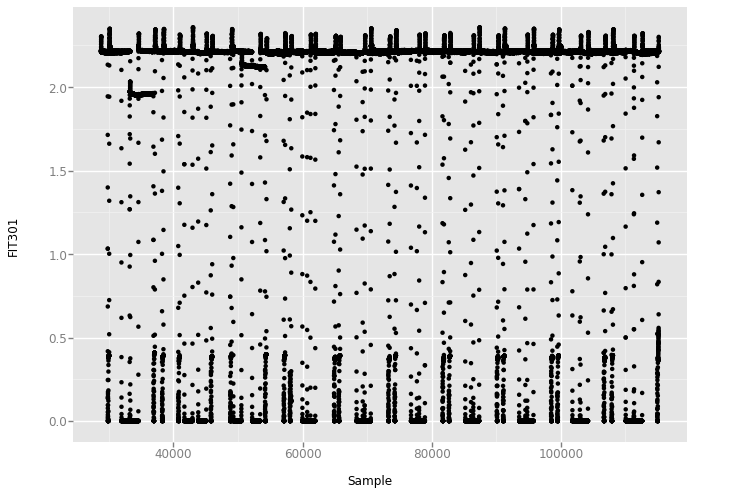

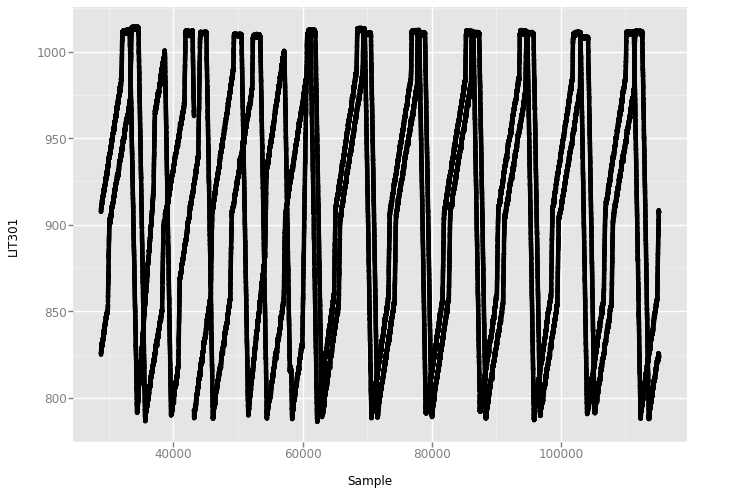

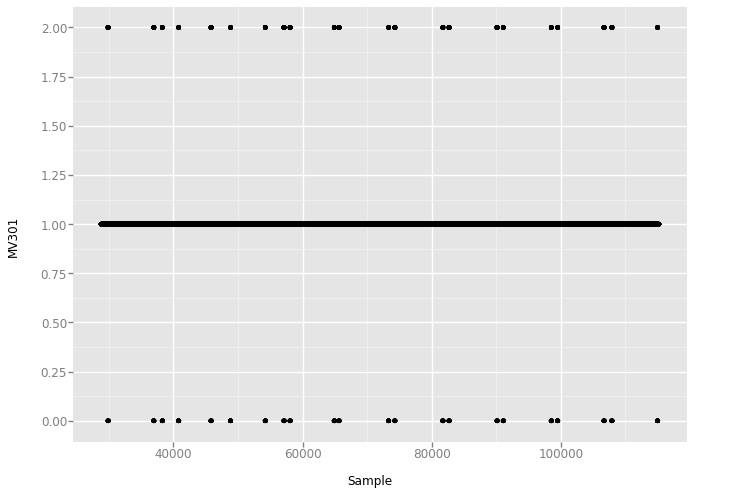

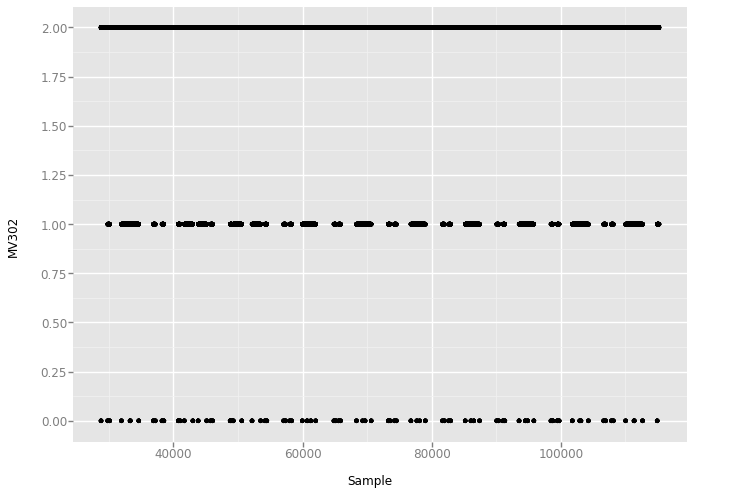

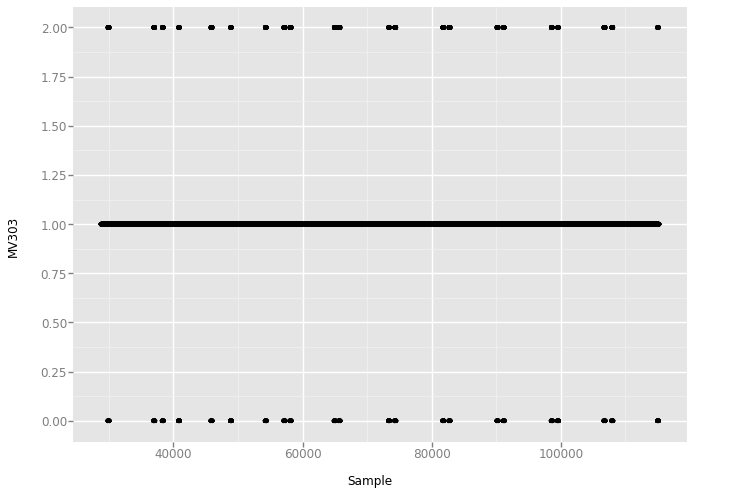

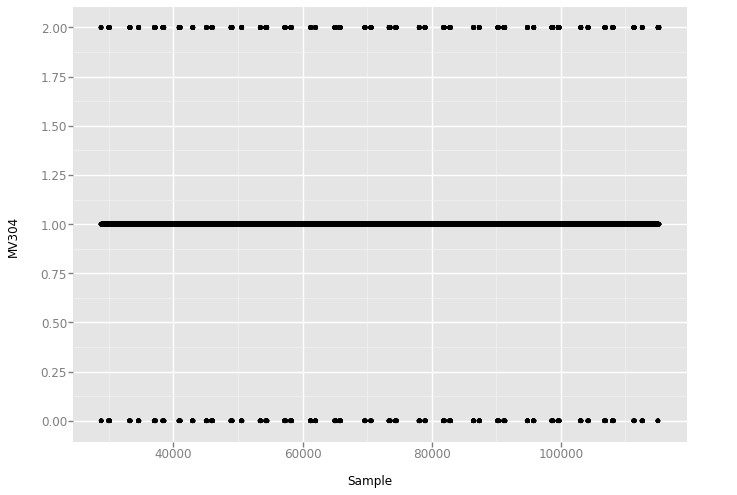

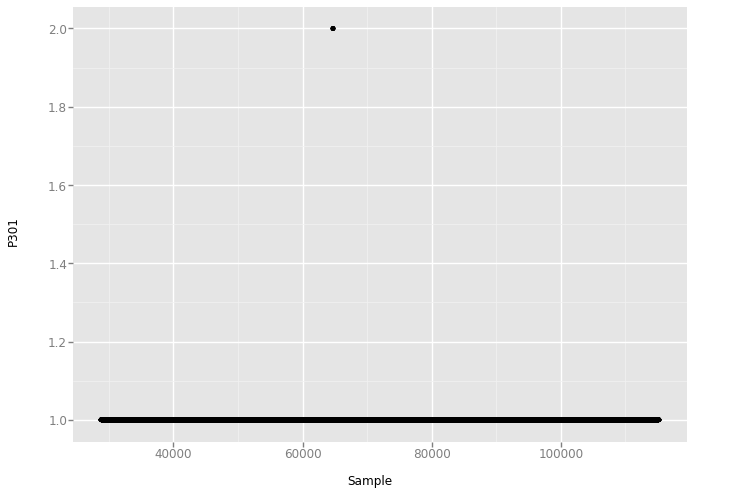

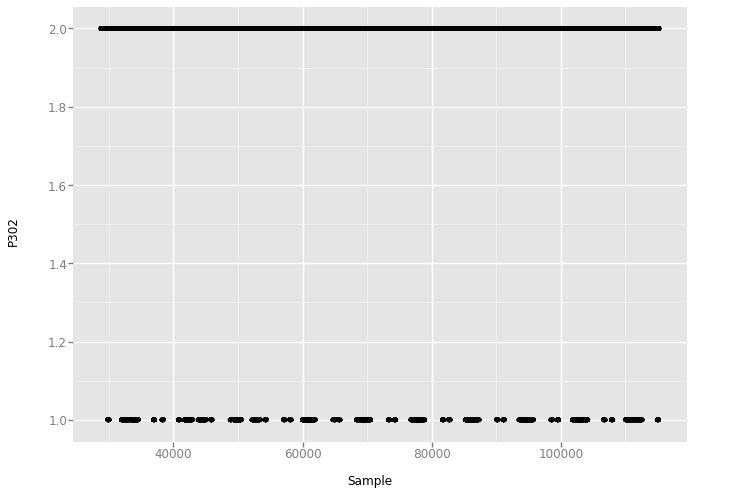

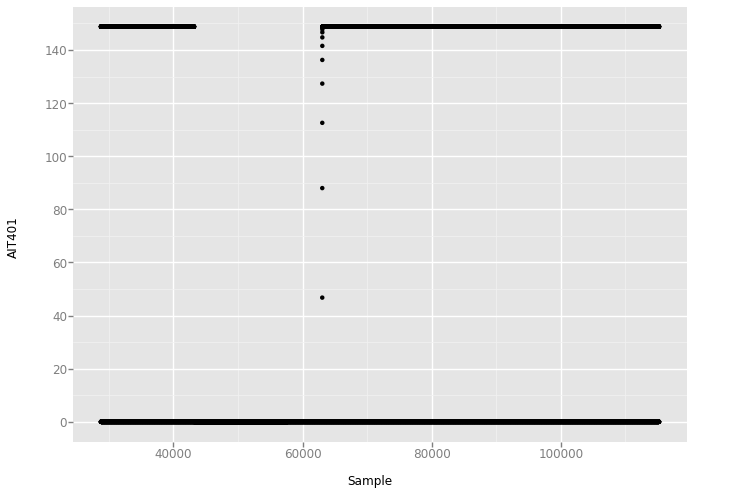

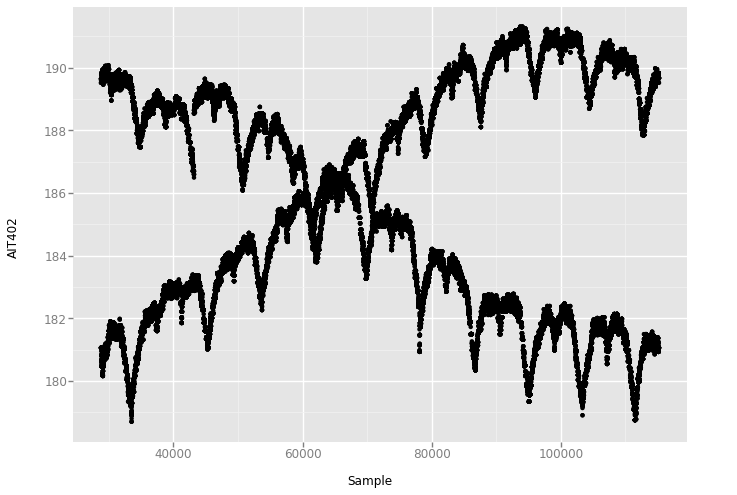

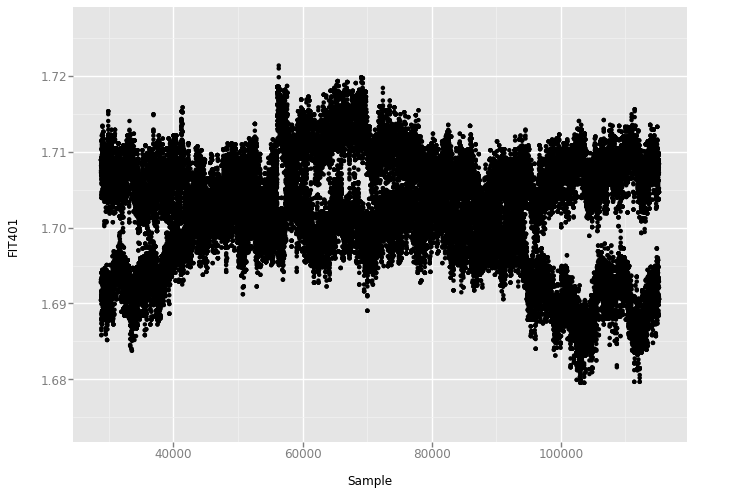

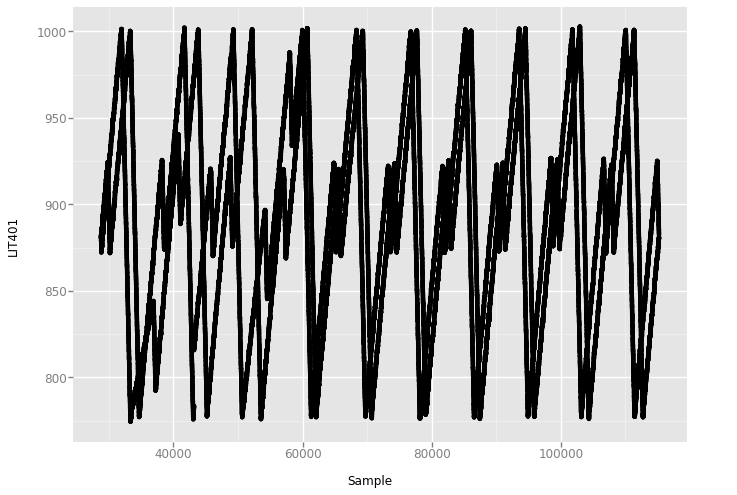

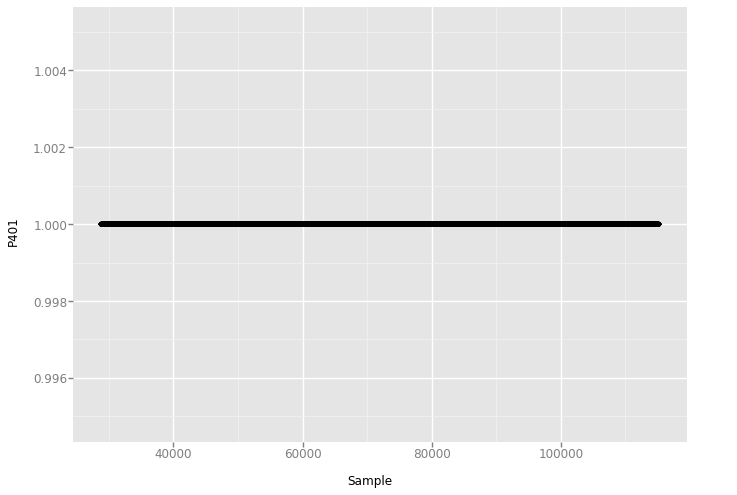

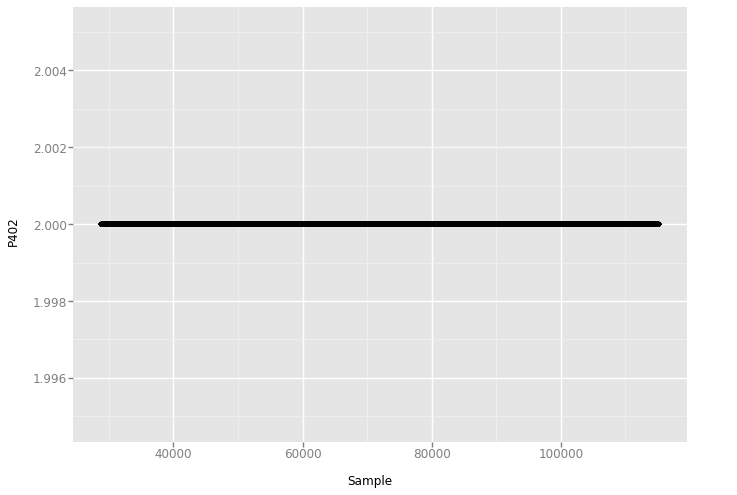

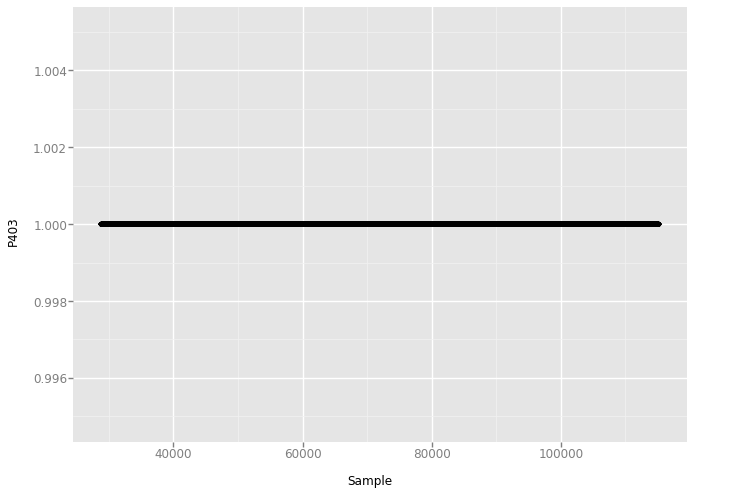

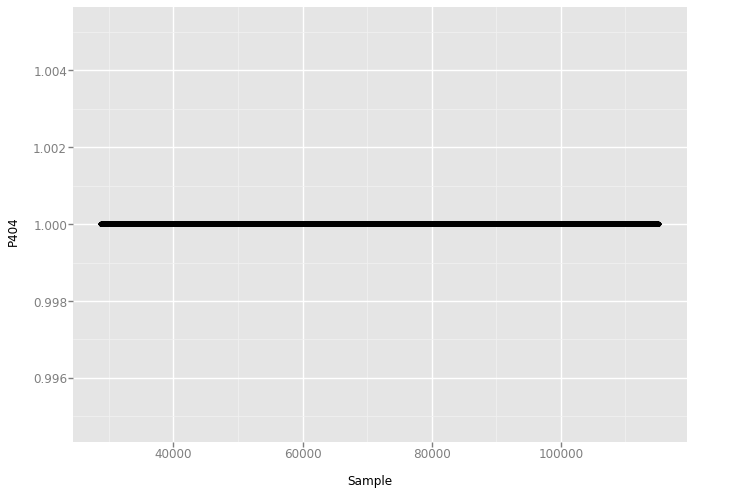

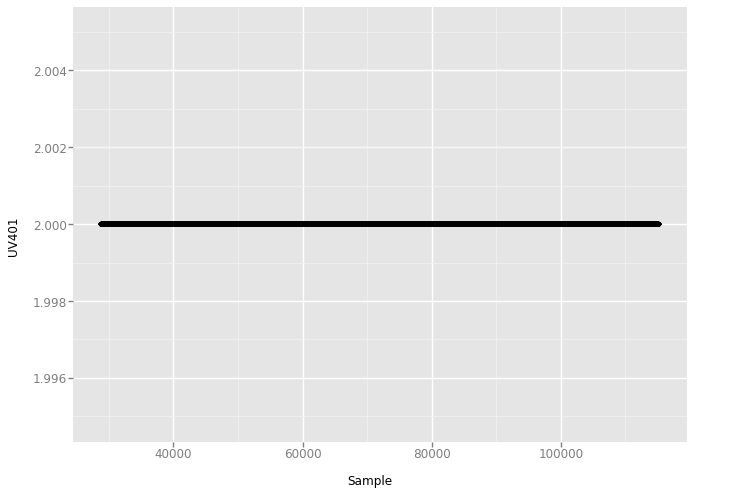

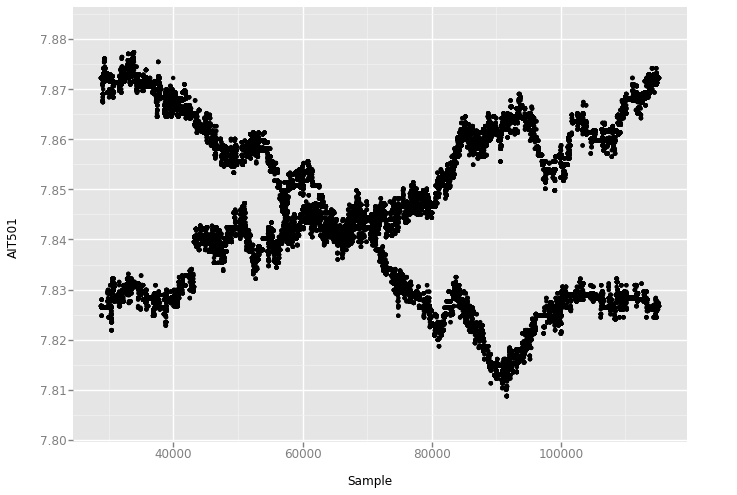

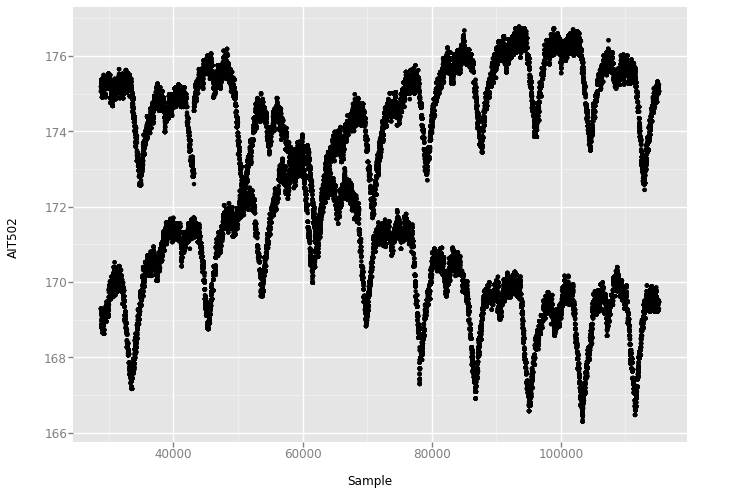

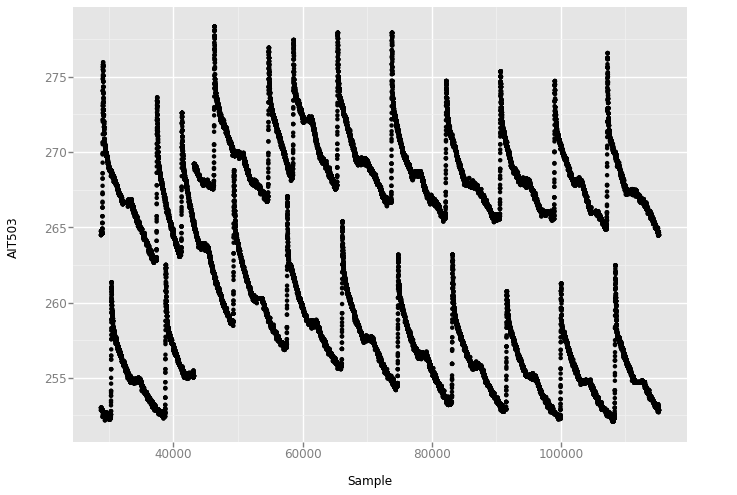

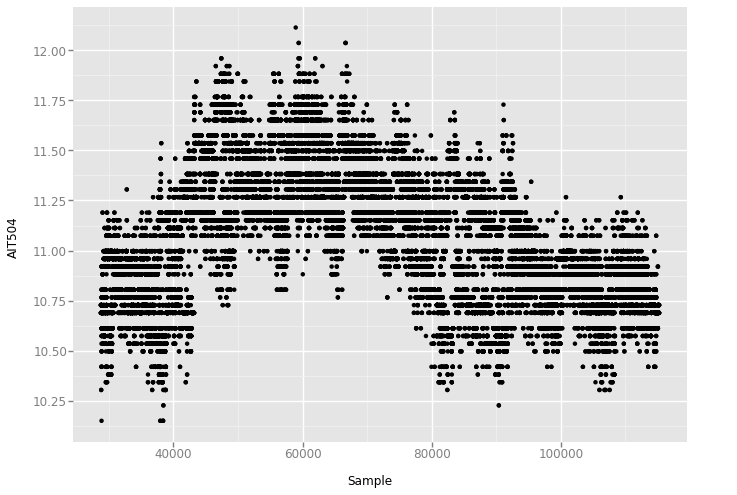

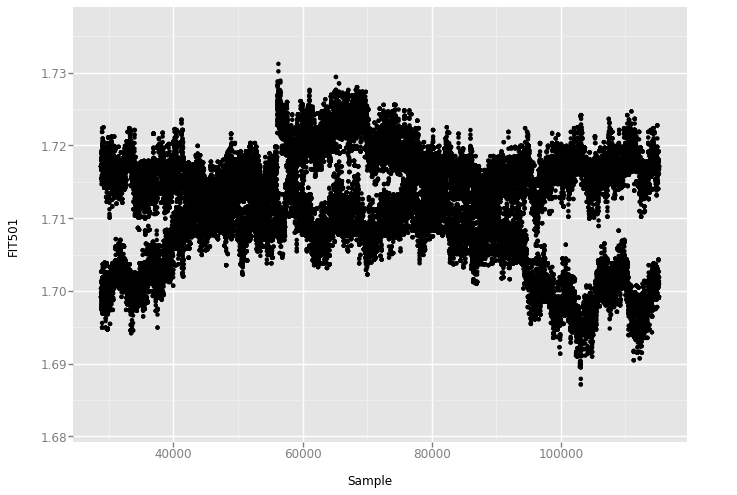

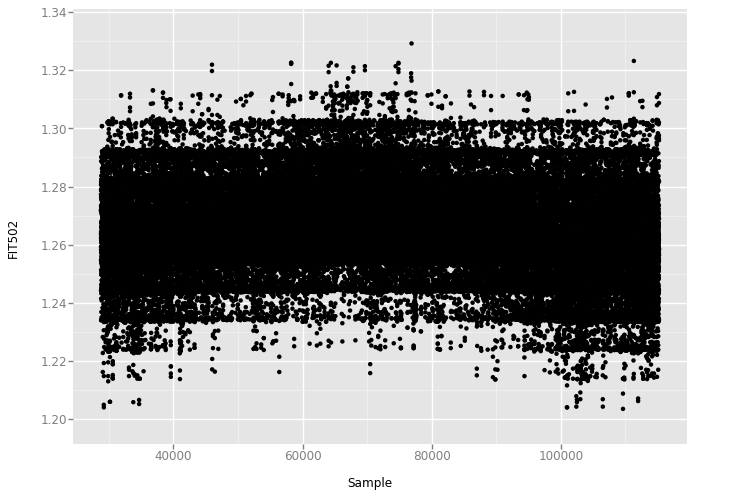

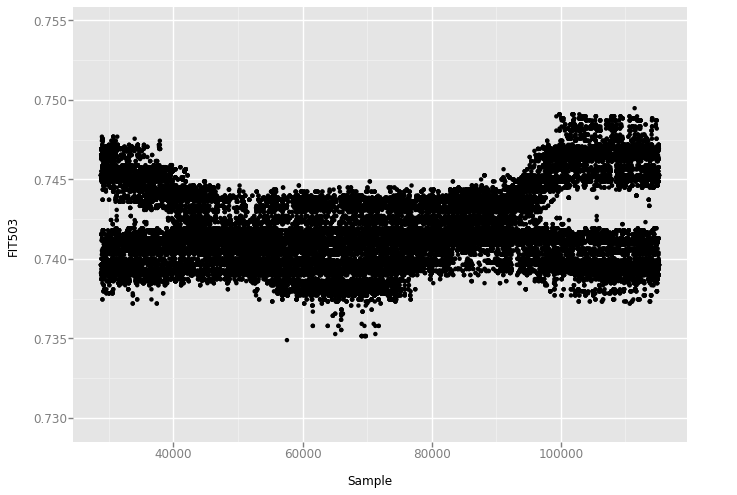

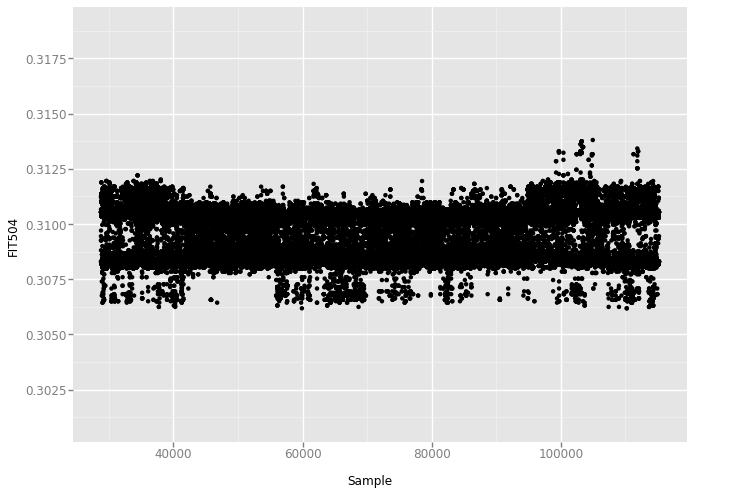

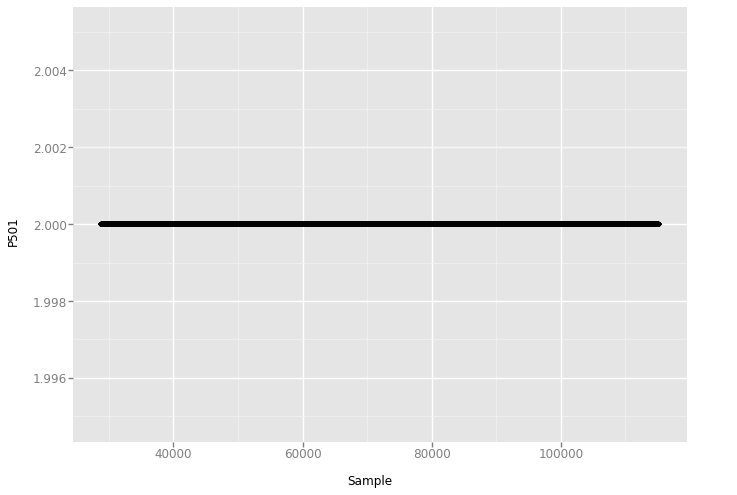

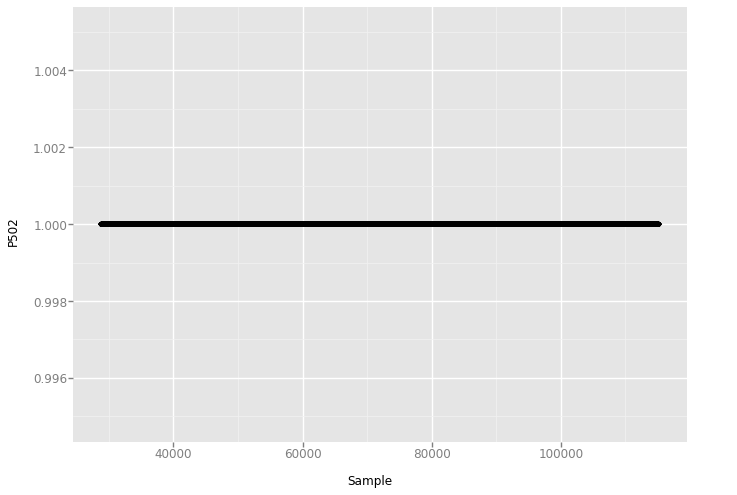

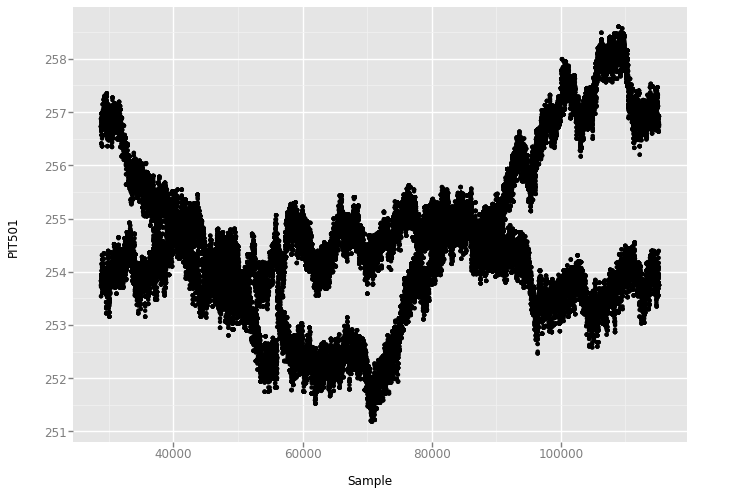

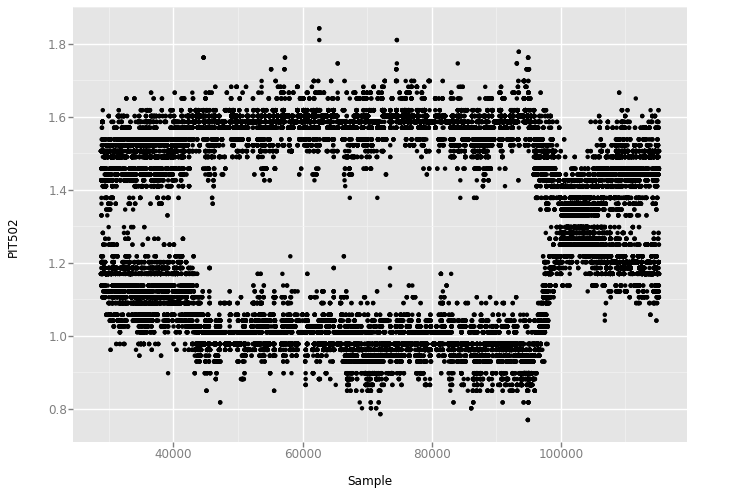

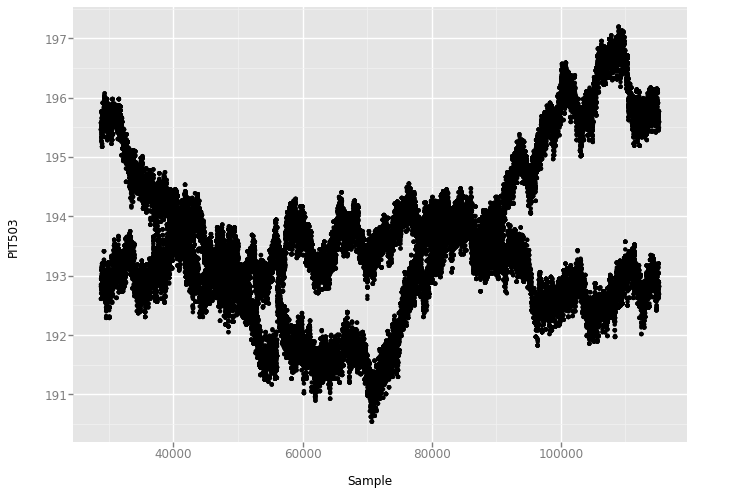

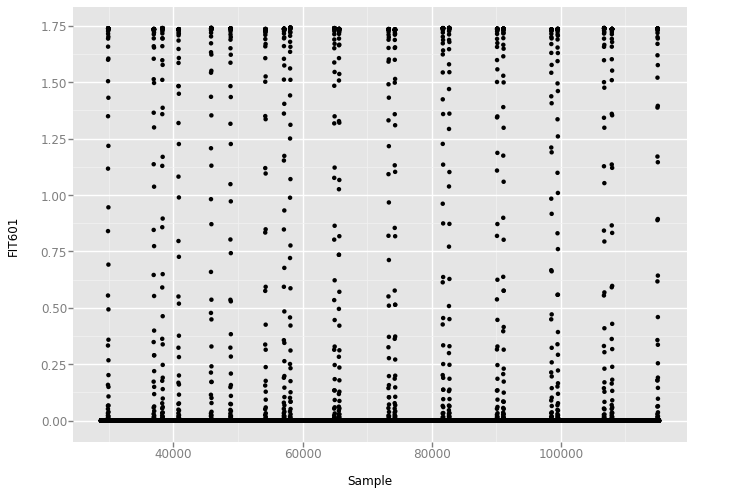

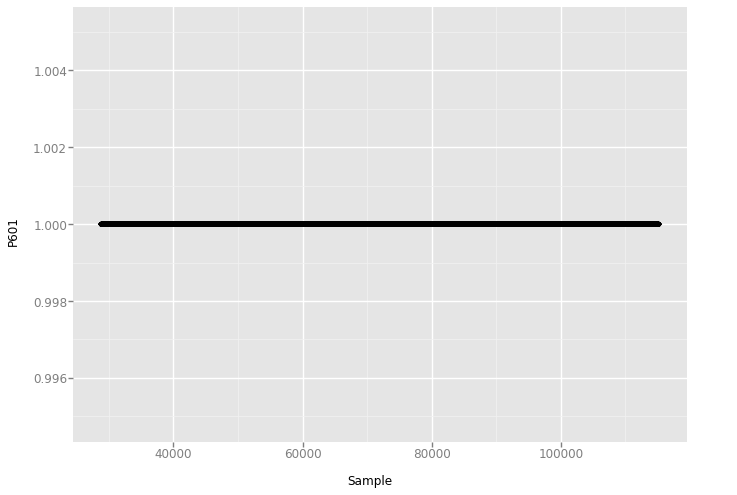

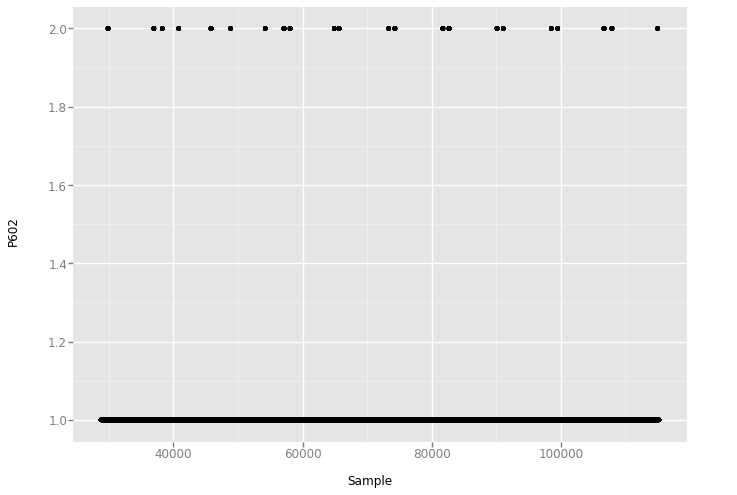

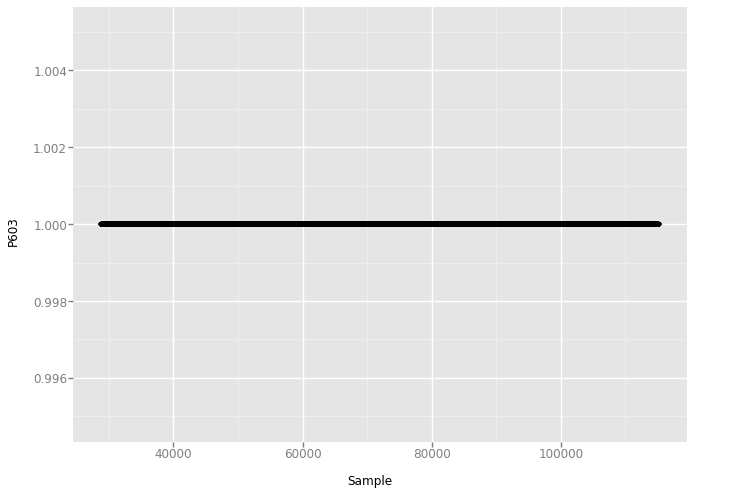

In [39]:
for feature in features:
    plot = ggplot(aes(x='Sample', y=feature), data=data_day2) + \
    geom_point()
    plot.show()